In [1]:
'''
Use tf2 env with this as it has Cuda for GPU
This is to try to improve on last model

Objective: 
Input: taking RGB image from front facing camera 640x480 - in same 3:4 ratio as tesla
Output: semantic image of same dimension

1. We ask Chat GPT for direction

2. We will use generators to deal with image size/capacity

3. We will re-use previously created custom loss function

'''


'\nThis is to try to improve on last model\n\nObjective: \nInput: taking RGB image from front facing camera\nOutput: semantic image of same dimension\n\n'

In [2]:
# imports
import carla #the sim library itself
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
from matplotlib import pyplot as plt #to show images in this notebook



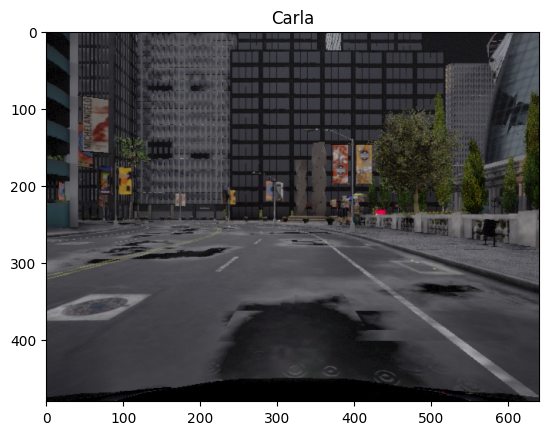

In [3]:
# input example
img = cv2.imread('C:\\SelfDrive\\Semantic segmentation\\out_sem\\rgb\\1679033081542741300.png')
carla_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(carla_im)
plt.title('Carla')
plt.show()

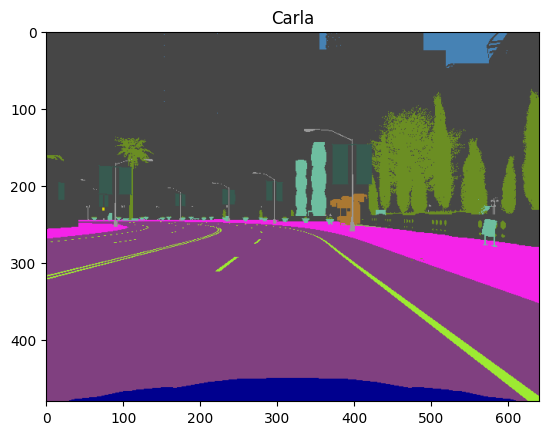

In [4]:
# output example
img = cv2.imread('C:\\SelfDrive\\Semantic segmentation\\out_sem\\sem\\1679033081542741300.png')
carla_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(carla_im)
plt.title('Carla')
plt.show()

In [5]:
# suggested by Chat GPT U-net model architecture:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Mid-level
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder
    up3 = layers.UpSampling2D(size=(2, 2))(pool2)
    concat3 = layers.Concatenate(axis=-1)([conv1, up3])
    conv3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(concat3)
    conv3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)

    # Output layer
    output = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv3)

    model = models.Model(inputs=inputs, outputs=output)
    return model

# Set input shape (assuming 256x256 RGB images)
input_shape = (256, 256, 3)

# Create the model
model = unet_model(input_shape)

# Display the model summary
model.summary()

In [ ]:
# previous loss function used
from keras import backend as K
def weighted_binary_crossentropy( y_true, y_pred, weight=1. ) :
    y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
    logloss = -(y_true * K.log(y_pred) * weight + (1 - y_true) * K.log(1 - y_pred))
    return K.mean( logloss, axis=-1) 

In [6]:
#working out image folders
import os

input_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\rgb'
output_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\sem'
# Get a list of image file paths and labels
input_image_files = [file for file in os.listdir(input_img_dir) if file.endswith('.png')]
output_image_files = [file for file in os.listdir(input_img_dir) if file.endswith('.png')]

In [14]:
img.shape

(480, 640, 3)

In [2]:
# starting form working generator approach eaxmple from RL tutorial - workings.ipynb

import os
import random
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
import tensorflow as tf
from keras import layers, models

from keras import backend as K

# define source folders
input_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\rgb'
output_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\sem'

# Define the parameters for image preprocessing and augmentation
batch_size = 64
input_shape=(480,640,3)
# Get a list of image file paths and labels
input_image_files = [file for file in os.listdir(input_img_dir) if file.endswith('.png')]
random.shuffle(input_image_files)

# Create a custom data generator
def custom_data_generator(input_images, batch_size):
    num_samples = len(input_images)
    while True:
        indices = np.random.randint(0, num_samples, batch_size)
        batch_images = []  #input images
        batch_sem_images = [] # output images
        for idx in indices:
            input_image_name = input_images[idx]
            in_image = preprocess_image(os.path.join(input_img_dir,input_image_name))
            batch_images.append(in_image)
            out_image = preprocess_image(os.path.join(output_img_dir,input_image_name)) #share same name so name of input image is used to ensure same picture in both
            batch_sem_images.append(out_image)
        yield np.array(batch_images), np.array(batch_sem_images)

# Preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

def weighted_binary_crossentropy( y_true, y_pred, weight=1. ) :
    y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
    logloss = -(y_true * K.log(y_pred) * weight + (1 - y_true) * K.log(1 - y_pred))
    return K.mean( logloss, axis=-1) 

def create_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Mid-level
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Decoder
    up3 = layers.UpSampling2D(size=(4, 4))(pool2)
    #print('conv1 shape: ',conv1.shape,'up3 shape: ',up3.shape)
    
    concat3 = layers.Concatenate(axis=-1)([conv1, up3])
    conv3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(concat3)
    conv3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)

    # Output layer
    output = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv3)

    model = models.Model(inputs=inputs, outputs=output)
    return model

# Split the data into training and validation sets
split_index = int(len(input_image_files) * 0.8)  # 80% for training, 20% for validation
train_files, val_files = input_image_files[:split_index], input_image_files[split_index:]

# Create data generators for training and validation
train_generator = custom_data_generator(train_files, batch_size)
val_generator = custom_data_generator(val_files, batch_size)

model = create_model(input_shape=input_shape)
model.summary()
model.compile(loss=weighted_binary_crossentropy,
              optimizer='adam')

# Train the model
model.fit(train_generator, steps_per_epoch=len(train_files) // batch_size, epochs=10,
          validation_data=val_generator, validation_steps=len(val_files) // batch_size)



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 480, 640, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_8 (Conv2D)              (None, 480, 640, 32  9248        ['conv2d_7[0][0]']               
                                )                                                           

NotFoundError: Graph execution error:

Detected at node 'model_1/conv2d_7/Relu' defined at (most recent call last):
    File "c:\Users\Vadim\.conda\envs\tf2\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Vadim\.conda\envs\tf2\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "c:\Users\Vadim\.conda\envs\tf2\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "c:\Users\Vadim\.conda\envs\tf2\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\ipykernel\ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Vadim\AppData\Local\Temp\ipykernel_7908\3834323819.py", line 92, in <module>
      validation_data=val_generator, validation_steps=len(val_files) // batch_size)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\activations.py", line 318, in relu
      x, alpha=alpha, max_value=max_value, threshold=threshold
    File "c:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model_1/conv2d_7/Relu'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2140143616 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2140143616 bytes.
  Profiling failure on CUDNN engine 6#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16798208 bytes.
  Profiling failure on CUDNN engine 6: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16798208 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 36691968 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 36691968 bytes.
  Profiling failure on CUDNN engine 7#TC: RESOURCE_EXHAUSTED: Allocating 6193165824 bytes exceeds the memory limit of 4294967296 bytes.
  Profiling failure on CUDNN engine 7: RESOURCE_EXHAUSTED: Allocating 6193165824 bytes exceeds the memory limit of 4294967296 bytes.
	 [[{{node model_1/conv2d_7/Relu}}]] [Op:__inference_train_function_1422]

In [ ]:
'''
next ideas:
1. Try running in tf2 to try using GPU, yes tf2 had CUDA but ran out of memory
2. Use loss="sparse_categorical_crossentropy" or error (MSE)
2 convert 3 colour values (RGB) into specific classes below, make 1 dim out of and use loss="sparse_categorical_crossentropy"
0	Unlabeled	(0, 0, 0)	Elements that have not been categorized are considered Unlabeled. This category is meant to be empty or at least contain elements with no collisions.
1	Building	(70, 70, 70)	Buildings like houses, skyscrapers,... and the elements attached to them.
E.g. air conditioners, scaffolding, awning or ladders and much more.
2	Fence	(100, 40, 40)	Barriers, railing, or other upright structures. Basically wood or wire assemblies that enclose an area of ground.
3	Other	(55, 90, 80)	Everything that does not belong to any other category.
4	Pedestrian	(220, 20, 60)	Humans that walk or ride/drive any kind of vehicle or mobility system.
E.g. bicycles or scooters, skateboards, horses, roller-blades, wheel-chairs, etc.
5	Pole	(153, 153, 153)	Small mainly vertically oriented pole. If the pole has a horizontal part (often for traffic light poles) this is also considered pole.
E.g. sign pole, traffic light poles.
6	RoadLine	(157, 234, 50)	The markings on the road.
7	Road	(128, 64, 128)	Part of ground on which cars usually drive.
E.g. lanes in any directions, and streets.
8	SideWalk	(244, 35, 232)	Part of ground designated for pedestrians or cyclists. Delimited from the road by some obstacle (such as curbs or poles), not only by markings. This label includes a possibly delimiting curb, traffic islands (the walkable part), and pedestrian zones.
9	Vegetation	(107, 142, 35)	Trees, hedges, all kinds of vertical vegetation. Ground-level vegetation is considered Terrain.
10	Vehicles	(0, 0, 142)	Cars, vans, trucks, motorcycles, bikes, buses, trains.
11	Wall	(102, 102, 156)	Individual standing walls. Not part of a building.
12	TrafficSign	(220, 220, 0)	Signs installed by the state/city authority, usually for traffic regulation. This category does not include the poles where signs are attached to.
E.g. traffic- signs, parking signs, direction signs...
13	Sky	(70, 130, 180)	Open sky. Includes clouds and the sun.
14	Ground	(81, 0, 81)	Any horizontal ground-level structures that does not match any other category. For example areas shared by vehicles and pedestrians, or flat roundabouts delimited from the road by a curb.



'''

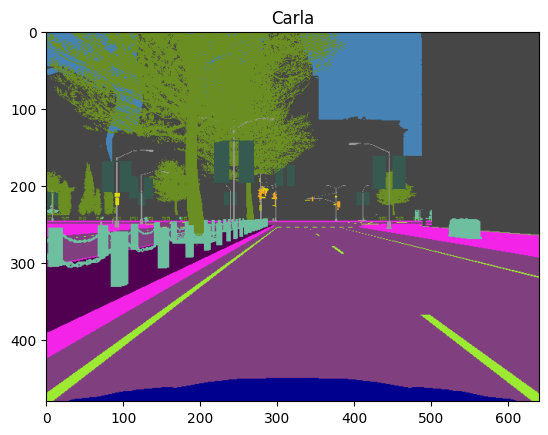

In [6]:
'''
trying making labeled vesrion of target image 
where RGB dims are replaced with labels 0,1,2... representing calss labels
'''
import cv2
from matplotlib import pyplot as plt #to show images in this notebook

img = cv2.imread('C:\\SelfDrive\\Semantic segmentation\\out_sem\\sem\\1679033467871703900.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Carla')
plt.show()

In [44]:
img.shape

(480, 640, 3)

In [16]:
# now confirm all important colours - this code only shows in white art of image where colour matches
''' 
IMPORTANT - this is after BGR To RGB conversion img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) is applied to image
Road	(128, 64, 128) - confirmed
lane markings	(157, 234, 50)	confirmed
SideWalk	(244, 35, 232)	confirmed
TrafficSign	(220, 220, 0) confirmed
Building	(70, 70, 70) confirmed
Vehicles	(0, 0, 142) confirmed
Pedestrian	(220, 20, 60)
Ground	(81, 0, 81) confirmed - very dark type of  magenta
Pole	(153, 153, 153) confirmed
'''

lower_colour = np.array([153, 153, 153],dtype='uint8')
upper_colour = np.array([153, 153, 153],dtype='uint8')
road_mask = cv2.inRange(img,lower_colour,upper_colour)
cv2.imshow('mask searched colour',road_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [17]:
'''
Now we need to group objects into - for now ignore pedestrians
0 - everything else
1 - drivable road - (128, 64, 128)
2 - lane markings - (157, 234, 50)
3 - cars - (0, 0, 142)
4 - road signs - (220, 220, 0)

'''

'\nNow we need to group objects into - for now ignore pedestrians\n0 - drivable road - (128, 64, 128)\n1 - lane markings - (157, 234, 50)\n3 - cars - (0, 0, 142)\n4 - road signs - (220, 220, 0)\n5 - everything else\n'

In [51]:
# now we make a special process image for semantic images to replace RGB dims with one-hot
# this is a very slow way to convert each image
# FIND faster way!!!

# colour mapping
color_to_label_mapping = {
    (128, 64, 128): 1,
    (157, 234, 50): 2,
    (0, 0, 142): 3,
    (220, 220, 0): 4  
}

# function to turn on RGB pixel into on-hot
def onehot_from_pixel(pixel):
    one_hot = [0.,0.,0.,0.,0]
    match_class = 0
    for color, label in color_to_label_mapping.items():
        if np.array_equal(pixel, np.array(color)):
            match_class = label
    one_hot [match_class]=1. 
    return one_hot

def preprocess_sem_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # define empty array
    new_array = np.zeros((image.shape[0],image.shape[1],5))
    vectorised_func = np.vectorize(onehot_from_pixel)
    #iterate over all pixels
    #for h in range(image.shape[0]):
    #    for w in range(image.shape[1]):
    #        new_array[h][w] = onehot_from_pixel(image[h][w])
    return vectorised_func(new_array)



# Save or further process the result as needed
#result_image = Image.fromarray(result)



In [52]:
result = preprocess_sem_image('C:\\SelfDrive\\Semantic segmentation\\out_sem\\sem\\1679033467871703900.png')

ValueError: setting an array element with a sequence.

In [7]:
# this approach works but it returns 480x649 where each "pixel" is value 1, 2, 3 - not yet one-hot
def rgb_to_onehot(rgb_image, color_to_label_mapping):
    # Convert the RGB image to a NumPy array
    image_array = np.array(rgb_image)

    # Create an empty array for one-hot encoded labels
    one_hot_labels = np.zeros((image_array.shape[0],image_array.shape[1]), dtype=np.uint8)

    # Replace colors with one-hot labels
    for color, label in color_to_label_mapping.items():
        mask = np.all(image_array == np.array(color), axis=-1)
        one_hot_labels[mask] = label

    return one_hot_labels

# Example: Define color to label mapping
color_to_label_mapping = {
    (128, 64, 128): 1,
    (157, 234, 50): 2,
    (0, 0, 142): 3,
    (220, 220, 0): 4  
}

# Load your RGB image using any other library (e.g., OpenCV)
# For simplicity, let's assume you have a 3x3 RGB image
rgb_image = img

# Convert RGB to one-hot
one_hot_result = rgb_to_onehot(rgb_image, color_to_label_mapping)



In [8]:
one_hot_result[320][320]

1

In [9]:
#chat gpt to one-hot
import numpy as np

def convert_to_one_hot(input_array, num_classes):
    """
    Convert a 2D array into a one-hot encoded 3D array.

    Parameters:
    - input_array: 2D array to be converted.
    - num_classes: Number of classes for one-hot encoding.

    Returns:
    - one_hot_array: 3D one-hot encoded array.
    """
    unique_classes = np.unique(input_array)
    if not set(unique_classes).issubset(set(range(num_classes))):
        raise ValueError("Input array contains classes outside the range [0, num_classes).")

    one_hot_array = np.eye(num_classes)[input_array]
    return one_hot_array

# Example usage:
# Suppose you have a 2D array 'input_array' with values representing classes, and you want to one-hot encode it with 5 classes.
input_array = one_hot_result

num_classes = 5
one_hot_result_final = convert_to_one_hot(one_hot_result, num_classes)

print("Original 2D array:")
print(input_array.shape)
print("\nOne-hot encoded 3D array:")
print(one_hot_result_final.shape)
    

Original 2D array:
(480, 640)

One-hot encoded 3D array:
(480, 640, 5)


In [10]:
#this confirm pixel 320x320 is road
one_hot_result_final[320][320]

array([0., 1., 0., 0., 0.])

In [11]:
# comparing to corner pixel - which is nothing
one_hot_result_final[0][0]

array([1., 0., 0., 0., 0.])

In [19]:
# now combine both
'''
This is final working version to encode a semantic image into one-hot format
where image is going from (h,w,3) to (h,w,5) where 5 is number of classes
this willa lso automatically adjust 5 to whatever mapping changes yo make, 
e.g. if yo make 7 class mapping then it will clerat (h,w,7) shape

'''
# Define color to label mapping
color_to_label_mapping = {
    (128, 64, 128): 1,  #road
    (157, 234, 50): 2,  #lane marking
    (0, 0, 142): 3,     #cars
    (220, 220, 0): 4    #road signs
}

def rgb_to_onehot(rgb_image, color_to_label_mapping):
    # Convert the RGB image to a NumPy array
    image_array = np.array(rgb_image)

    # Create an empty array for one-hot encoded labels
    one_hot_labels = np.zeros((image_array.shape[0],image_array.shape[1]), dtype=np.uint8)

    # Replace colors with one-hot labels
    for color, label in color_to_label_mapping.items():
        mask = np.all(image_array == np.array(color), axis=-1)
        one_hot_labels[mask] = label
    # this conts classes from maping dict and extra one for all others
    num_classes = len(color_to_label_mapping.items())+1
    unique_classes = np.unique(one_hot_labels)
    if not set(unique_classes).issubset(set(range(num_classes))):
        raise ValueError("Input array contains classes outside the range [0,", num_classes ,").")
    # apply one-hot
    one_hot_array = np.eye(num_classes)[one_hot_labels]
    return one_hot_array
    

# Convert RGB to one-hot
one_hot_result = rgb_to_onehot(img, color_to_label_mapping)


In [20]:
one_hot_result[320][320]

array([0., 1., 0., 0., 0.])

In [21]:
one_hot_result[0][0]

array([1., 0., 0., 0., 0.])

In [ ]:
# next we need a custom loss function to focus car's attention in the more important part of the image 
# this is chatGPT idea
# we can change it taking the weight from the mask file to allow several degrees of importance for image parts
import tensorflow as tf
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import backend as K

def custom_categorical_loss(mask, weight_factor=2.0, num_classes=NUM_CLASSES):
    """
    Custom categorical cross-entropy loss with weighted pixels based on a given mask.

    Parameters:
    - mask: A binary mask indicating the regions to be prioritized.
    - weight_factor: Weighting factor for the specified regions (default is 2.0).
    - num_classes: Number of classes in the segmentation task.

    Returns:
    - loss: Custom categorical cross-entropy loss.
    """
    def loss(y_true, y_pred):
        # Convert mask to a tensor
        mask_tensor = K.constant(mask, dtype=tf.float32)

        # Weight the mask regions with the specified factor
        weighted_mask = mask_tensor * weight_factor

        # Compute standard categorical cross-entropy loss
        standard_loss = categorical_crossentropy(y_true, y_pred)

        # Apply the weighted mask to the loss
        weighted_loss = weighted_mask * standard_loss

        # Calculate the mean loss over all pixels and classes
        return K.mean(weighted_loss)

    return loss

# Example usage:
# Assuming you have a model and your dataset with masks
model = ...

# Define your mask (binary mask with the same size as the images)
mask = ...

# Compile the model using the custom loss function
model.compile(optimizer='adam', loss=custom_categorical_loss(mask))

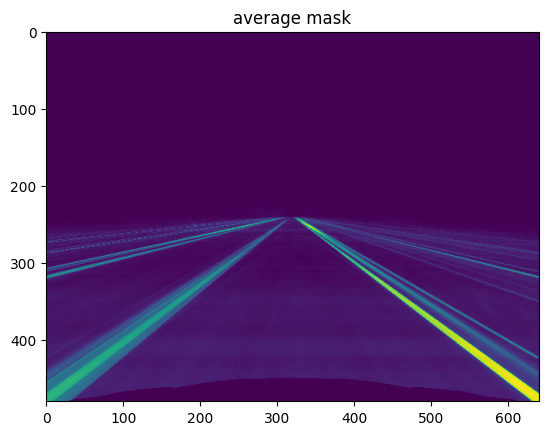

In [1]:
# creating mask - use previous masking works to find good regions

#copy old code
from matplotlib import pyplot as plt #to show images in this notebook
import os
import numpy as np
import cv2
# trying to measure how imbalanced lane masks are:
SIZE_X = 640
SIZE_Y = 480
msk_path = 'c:/SelfDrive/Semantic Segmentation/out_sem/msk_ln'
msk_images = os.listdir(msk_path)
img_count = len(msk_images)
x =  np.zeros(shape=(img_count,SIZE_Y,SIZE_X),dtype=np.float16)

i = 0
for file in msk_images:
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,0)
        x[i] = msk/255
        i += 1

avg_mask = np.average(x,axis=0)

plt.imshow(avg_mask)
plt.title('average mask')
plt.show()

In [2]:
type(input_img)

numpy.ndarray

In [3]:
avg_mask.shape

(480, 640)

In [6]:
avg_mask[479][0]

0.2068

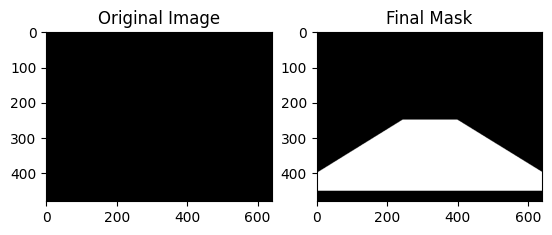

In [67]:
# figure out how to add triangles to a mask
# code below adds 2 triangle and 2 rectangle masks to the image
from matplotlib.path import Path# Define the vertices of the triangle

# constants for masking
start_h = 0.52 # ingnore height up to this
end_h = 0.94 # ignore bottom height from this 
triangle_h = 1.6 # multiplier from start_h for triangle
triangle_w = 0.38 # % of width ignored by triangle

#take shape from any above image
rows, cols = avg_mask.shape[0], avg_mask.shape[1]

input_img = np.ones((rows, cols), dtype=np.uint8)

# first triangle
triangle_vertices = np.array([[0,int(input_img.shape[0]*start_h)], [0,int(start_h *input_img.shape[0] * triangle_h)], [int(input_img.shape[1]*triangle_w),int(input_img.shape[0]*start_h)]])
triangle_path = Path(triangle_vertices)
# Create a 2D grid of coordinates
x, y = np.meshgrid(np.arange(cols), np.arange(rows))
# Flatten the coordinate grids and create an array of (x, y) points
points = np.column_stack((x.flatten(), y.flatten()))
# Create a boolean mask for the points inside the triangle
triangle_mask1 = triangle_path.contains_points(points).reshape((rows, cols))
# Create a copy of the original image with the triangle sliced

# second triangle
triangle_vertices = np.array([[int(input_img.shape[1]*(1-triangle_w)),int(input_img.shape[0]*start_h)], [input_img.shape[1],int(start_h *input_img.shape[0] * triangle_h)], [input_img.shape[1],int(input_img.shape[0]*start_h)]])
triangle_path = Path(triangle_vertices)
# Create a 2D grid of coordinates
x, y = np.meshgrid(np.arange(cols), np.arange(rows))
# Flatten the coordinate grids and create an array of (x, y) points
points = np.column_stack((x.flatten(), y.flatten()))
# Create a boolean mask for the points inside the triangle
triangle_mask2 = triangle_path.contains_points(points).reshape((rows, cols))

# rectangle to ignore top
rectangle_vertices = np.array([[0, 0], [input_img.shape[1], int(input_img.shape[0]*start_h)+1]])
# Create a boolean mask for the rectangle
rectangle_mask1 = np.zeros_like(input_img, dtype=bool)
rectangle_mask1[
    np.min(rectangle_vertices[:, 1]):np.max(rectangle_vertices[:, 1]),
    np.min(rectangle_vertices[:, 0]):np.max(rectangle_vertices[:, 0]),
] = True

# rectangle to ignore bottom
rectangle_vertices = np.array([[0,int(input_img.shape[0]*end_h)],[input_img.shape[1],input_img.shape[0]]])
# Create a boolean mask for the rectangle
rectangle_mask2 = np.zeros_like(input_img, dtype=bool)
rectangle_mask2[
    np.min(rectangle_vertices[:, 1]):np.max(rectangle_vertices[:, 1]),
    np.min(rectangle_vertices[:, 0]):np.max(rectangle_vertices[:, 0]),
] = True


mask = np.copy(input_img)
mask[triangle_mask1] = 0  # Set non-triangle pixels to white
mask[triangle_mask2] = 0 # Set non-triangle pixels to white
mask[rectangle_mask1] = 0
mask[rectangle_mask2] = 0


# Display the original image and the sliced triangle
plt.subplot(1, 2, 1), plt.imshow(input_img, cmap='gray'), plt.title('Original Image')
plt.subplot(1, 2, 2), plt.imshow(mask, cmap='gray'), plt.title('Final Mask')
plt.show()

In [68]:
# make function to create a mask based on a sample an image (used just for sizing)

from matplotlib.path import Path# Define the vertices of the triangle

def get_loss_mask(image):
    # constants for masking
    start_h = 0.52 # ingnore height up to this
    end_h = 0.94 # ignore bottom height from this 
    triangle_h = 1.6 # multiplier from start_h for triangle
    triangle_w = 0.38 # % of width ignored by triangle

    #take shape from any above image
    rows, cols = image.shape[0], image.shape[1]

    input_img = np.ones((rows, cols), dtype=np.uint8)

    # first triangle
    triangle_vertices = np.array([[0,int(input_img.shape[0]*start_h)], [0,int(start_h *input_img.shape[0] * triangle_h)], [int(input_img.shape[1]*triangle_w),int(input_img.shape[0]*start_h)]])
    triangle_path = Path(triangle_vertices)
    # Create a 2D grid of coordinates
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    # Flatten the coordinate grids and create an array of (x, y) points
    points = np.column_stack((x.flatten(), y.flatten()))
    # Create a boolean mask for the points inside the triangle
    triangle_mask1 = triangle_path.contains_points(points).reshape((rows, cols))
    # Create a copy of the original image with the triangle sliced

    # second triangle
    triangle_vertices = np.array([[int(input_img.shape[1]*(1-triangle_w)),int(input_img.shape[0]*start_h)], [input_img.shape[1],int(start_h *input_img.shape[0] * triangle_h)], [input_img.shape[1],int(input_img.shape[0]*start_h)]])
    triangle_path = Path(triangle_vertices)
    # Create a 2D grid of coordinates
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    # Flatten the coordinate grids and create an array of (x, y) points
    points = np.column_stack((x.flatten(), y.flatten()))
    # Create a boolean mask for the points inside the triangle
    triangle_mask2 = triangle_path.contains_points(points).reshape((rows, cols))

    # rectangle to ignore top
    rectangle_vertices = np.array([[0, 0], [input_img.shape[1], int(input_img.shape[0]*start_h)+1]])
    # Create a boolean mask for the rectangle
    rectangle_mask1 = np.zeros_like(input_img, dtype=bool)
    rectangle_mask1[
        np.min(rectangle_vertices[:, 1]):np.max(rectangle_vertices[:, 1]),
        np.min(rectangle_vertices[:, 0]):np.max(rectangle_vertices[:, 0]),
    ] = True

    # rectangle to ignore bottom
    rectangle_vertices = np.array([[0,int(input_img.shape[0]*end_h)],[input_img.shape[1],input_img.shape[0]]])
    # Create a boolean mask for the rectangle
    rectangle_mask2 = np.zeros_like(input_img, dtype=bool)
    rectangle_mask2[
        np.min(rectangle_vertices[:, 1]):np.max(rectangle_vertices[:, 1]),
        np.min(rectangle_vertices[:, 0]):np.max(rectangle_vertices[:, 0]),
    ] = True


    mask = np.copy(input_img)
    mask[triangle_mask1] = 0  # Set non-triangle pixels to white
    mask[triangle_mask2] = 0 # Set non-triangle pixels to white
    mask[rectangle_mask1] = 0
    mask[rectangle_mask2] = 0
    return mask

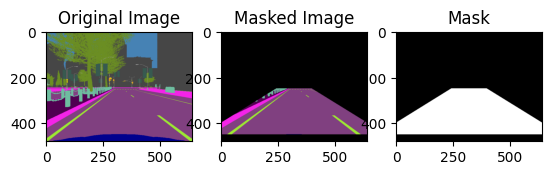

In [71]:
#example using mask function to select most impoirtant area of the image
import cv2
from matplotlib import pyplot as plt #to show images in this notebook

img = cv2.imread('C:\\SelfDrive\\Semantic segmentation\\out_sem\\sem\\1679033467871703900.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = get_loss_mask(img)


img_msk = cv2.bitwise_and(img, img, mask=mask)

# Display the original image and the sliced triangle
plt.subplot(1, 3, 1), plt.imshow(img), plt.title('Original Image')
plt.subplot(1, 3, 2), plt.imshow(img_msk), plt.title('Masked Image')
plt.subplot(1, 3, 3), plt.imshow(mask, cmap='gray'), plt.title('Mask')
plt.show()



In [72]:
# now the loss function
import tensorflow as tf
from keras.losses import categorical_crossentropy
from keras import backend as K

def custom_categorical_loss(mask, weight_factor=2.0):
    """
    Custom categorical cross-entropy loss with weighted pixels based on a given mask.

    Parameters:
    - mask: A binary mask indicating the regions to be prioritized.
    - weight_factor: Weighting factor for the specified regions (default is 2.0).
    - num_classes: Number of classes in the segmentation task.

    Returns:
    - loss: Custom categorical cross-entropy loss.
    """
    def loss(y_true, y_pred):
        # Convert mask to a tensor
        mask_tensor = K.constant(mask, dtype=tf.float32)

        # Weight the mask regions with the specified factor
        weighted_mask = mask_tensor * weight_factor

        # Compute standard categorical cross-entropy loss
        standard_loss = categorical_crossentropy(y_true, y_pred)

        # Apply the weighted mask to the loss
        weighted_loss = weighted_mask * standard_loss

        # Calculate the mean loss over all pixels and classes
        return K.mean(weighted_loss)

    return loss

In [1]:
# now continue with latest model
# but adding:
# 1. masking 
# 2. One-hot
# 2. Changing to categorical custom loss with emphasis on masked area of image
import os
import random
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
import tensorflow as tf
from keras import layers, models
from keras.losses import categorical_crossentropy
from keras import backend as K

from matplotlib.path import Path

# define source folders
input_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\rgb'
output_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\sem'

# Define the parameters for image preprocessing and augmentation
batch_size = 8

# function to create mask
def get_loss_mask(image):
    # constants for masking
    start_h = 0.52 # ingnore height up to this
    end_h = 0.94 # ignore bottom height from this 
    triangle_h = 1.6 # multiplier from start_h for triangle
    triangle_w = 0.38 # % of width ignored by triangle

    #take shape from any above image
    rows, cols = image.shape[0], image.shape[1]

    input_img = np.ones((rows, cols), dtype=np.uint8)

    # first triangle
    triangle_vertices = np.array([[0,int(input_img.shape[0]*start_h)], [0,int(start_h *input_img.shape[0] * triangle_h)], [int(input_img.shape[1]*triangle_w),int(input_img.shape[0]*start_h)]])
    triangle_path = Path(triangle_vertices)
    # Create a 2D grid of coordinates
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    # Flatten the coordinate grids and create an array of (x, y) points
    points = np.column_stack((x.flatten(), y.flatten()))
    # Create a boolean mask for the points inside the triangle
    triangle_mask1 = triangle_path.contains_points(points).reshape((rows, cols))
    # Create a copy of the original image with the triangle sliced

    # second triangle
    triangle_vertices = np.array([[int(input_img.shape[1]*(1-triangle_w)),int(input_img.shape[0]*start_h)], [input_img.shape[1],int(start_h *input_img.shape[0] * triangle_h)], [input_img.shape[1],int(input_img.shape[0]*start_h)]])
    triangle_path = Path(triangle_vertices)
    # Create a 2D grid of coordinates
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    # Flatten the coordinate grids and create an array of (x, y) points
    points = np.column_stack((x.flatten(), y.flatten()))
    # Create a boolean mask for the points inside the triangle
    triangle_mask2 = triangle_path.contains_points(points).reshape((rows, cols))

    # rectangle to ignore top
    rectangle_vertices = np.array([[0, 0], [input_img.shape[1], int(input_img.shape[0]*start_h)+1]])
    # Create a boolean mask for the rectangle
    rectangle_mask1 = np.zeros_like(input_img, dtype=bool)
    rectangle_mask1[
        np.min(rectangle_vertices[:, 1]):np.max(rectangle_vertices[:, 1]),
        np.min(rectangle_vertices[:, 0]):np.max(rectangle_vertices[:, 0]),
    ] = True

    # rectangle to ignore bottom
    rectangle_vertices = np.array([[0,int(input_img.shape[0]*end_h)],[input_img.shape[1],input_img.shape[0]]])
    # Create a boolean mask for the rectangle
    rectangle_mask2 = np.zeros_like(input_img, dtype=bool)
    rectangle_mask2[
        np.min(rectangle_vertices[:, 1]):np.max(rectangle_vertices[:, 1]),
        np.min(rectangle_vertices[:, 0]):np.max(rectangle_vertices[:, 0]),
    ] = True


    mask = np.copy(input_img)
    mask[triangle_mask1] = 0  # Set non-triangle pixels to white
    mask[triangle_mask2] = 0 # Set non-triangle pixels to white
    mask[rectangle_mask1] = 0
    mask[rectangle_mask2] = 0
    return mask

# Define color to label mapping
color_to_label_mapping = {
    (128, 64, 128): 1,  #road
    (157, 234, 50): 2,  #lane marking
    (0, 0, 142): 3,     #cars
    (220, 220, 0): 4    #road signs
}

def rgb_to_onehot(rgb_image, color_to_label_mapping):
    # Convert the RGB image to a NumPy array
    image_array = np.array(rgb_image)

    # Create an empty array for one-hot encoded labels
    one_hot_labels = np.zeros((image_array.shape[0],image_array.shape[1]), dtype=np.uint8)

    # Replace colors with one-hot labels
    for color, label in color_to_label_mapping.items():
        mask = np.all(image_array == np.array(color), axis=-1)
        one_hot_labels[mask] = label
    # this conts classes from maping dict and extra one for all others
    num_classes = len(color_to_label_mapping.items())+1
    unique_classes = np.unique(one_hot_labels)
    if not set(unique_classes).issubset(set(range(num_classes))):
        raise ValueError("Semantic image array contains # classes outside the range [0,", num_classes ,").")
    # apply one-hot
    one_hot_array = np.eye(num_classes)[one_hot_labels]
    return one_hot_array


# Get a list of image file paths and labels
input_image_files = [file for file in os.listdir(input_img_dir) if file.endswith('.png')]
random.shuffle(input_image_files)

#read one image to create mask
example_img = cv2.imread(os.path.join(input_img_dir,input_image_files[0]))
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
mask = get_loss_mask(example_img)

# get shape from the example image for the model
input_shape=example_img.shape


# Preprocess the image
def preprocess_rgb_image(image_path):
    image = cv2.imread(image_path)
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

def preprocess_sem_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    one_hot_result = rgb_to_onehot(image, color_to_label_mapping)
    return one_hot_result


# Create a custom data generator
def custom_data_generator(input_images, batch_size):
    num_samples = len(input_images)
    while True:
        indices = np.random.randint(0, num_samples, batch_size)
        batch_images = []  #input images
        batch_sem_images = [] # output images
        for idx in indices:
            input_image_name = input_images[idx]
            in_image = preprocess_rgb_image(os.path.join(input_img_dir,input_image_name))
            batch_images.append(in_image)
            out_image = preprocess_sem_image(os.path.join(output_img_dir,input_image_name)) #share same name so name of input image is used to ensure same picture in both
            batch_sem_images.append(out_image)
        yield np.array(batch_images), np.array(batch_sem_images)


def custom_categorical_loss(y_true, y_pred):
    """
    Custom categorical cross-entropy loss with weighted pixels based on a given mask.

    Parameters:
    - mask: A binary mask indicating the regions to be prioritized.
    - weight_factor: Weighting factor for the specified regions (default is 2.0).
    - num_classes: Number of classes in the segmentation task.

    Returns:
    - loss: Custom categorical cross-entropy loss.
    """
    weight_factor=2.0
    # Convert mask to a tensor
    mask_tensor = K.constant(mask, dtype=tf.float32)
    # Weight the mask regions with the specified factor
    weighted_mask = mask_tensor * weight_factor
    # Compute standard categorical cross-entropy loss
    standard_loss = categorical_crossentropy(y_true, y_pred)
    # Apply the weighted mask to the loss
    weighted_loss = weighted_mask * standard_loss
    # Calculate the mean loss over all pixels and classes
    loss=  K.mean(weighted_loss)
    return loss
def create_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Mid-level
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Decoder
    up3 = layers.UpSampling2D(size=(4, 4))(pool2)
        
    concat3 = layers.Concatenate(axis=-1)([conv1, up3])
    conv3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(concat3)
    conv3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)

    # Output layer where 5 should equal to num classes
    output = layers.Conv2D(5, (1, 1), activation='sigmoid')(conv3)

    model = models.Model(inputs=inputs, outputs=output)
    return model

# Split the data into training and validation sets
split_index = int(len(input_image_files) * 0.8)  # 80% for training, 20% for validation
train_files, val_files = input_image_files[:split_index], input_image_files[split_index:]

# Create data generators for training and validation
train_generator = custom_data_generator(train_files, batch_size)
val_generator = custom_data_generator(val_files, batch_size)

model = create_model(input_shape=input_shape)
model.summary()
model.compile(loss=custom_categorical_loss,
              optimizer='adam')

# Train the model
model.fit(train_generator, steps_per_epoch=len(train_files) // batch_size, epochs=20,
          validation_data=val_generator, validation_steps=len(val_files) // batch_size)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 480, 640, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 480, 640, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

KeyboardInterrupt: 

In [25]:
#save first
model.save("model\RGB to semantic model attempt2", overwrite=True,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)
  

INFO:tensorflow:Assets written to: model\RGB to semantic model attempt2\assets


INFO:tensorflow:Assets written to: model\RGB to semantic model attempt2\assets


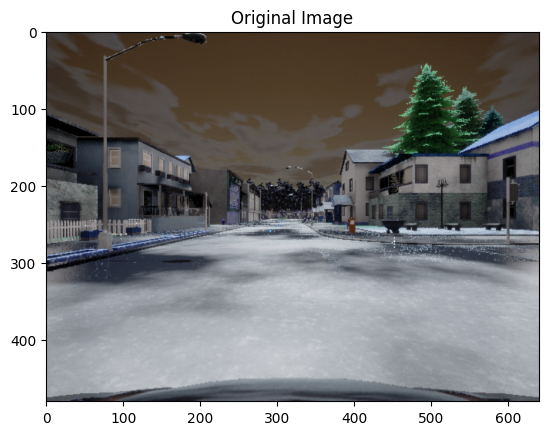

In [37]:
# now show work out how to show predictions from the model
from matplotlib import pyplot as plt #to show images in this notebook
# define reverse disctionary to go from one-hot to colours
color_to_label_mapping = {
    0: (0, 0, 0),  #Nothing
    1: (128, 64, 128),  #road
    2: (157, 234, 50),  #lane marking
    3: (0, 0, 142),     #cars
    4: (220, 220, 0)    #road signs
}

example_img = cv2.imread(os.path.join(input_img_dir,input_image_files[0]))
plt.subplot(1, 1, 1), plt.imshow(example_img), plt.title('Original Image')
plt.show()  

In [27]:
# predict
img = model(np.expand_dims(example_img, axis=0) / 255,training=False) # may need changing
img = (np.squeeze(img[0].numpy()))



In [29]:
# see prediction
img[230][230]

array([3.4765133e-01, 9.1492081e-01, 3.5620773e-01, 2.8695342e-01,
       6.2899297e-10], dtype=float32)

In [32]:
#test argmax to pick max probability class
np.argmax(img[230][230])


1

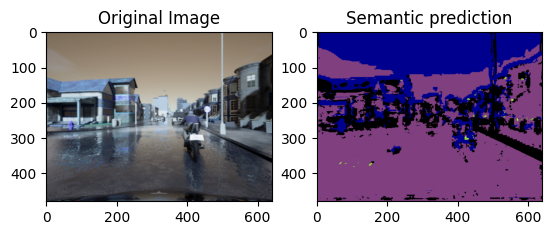

In [50]:
# now show predictions from the model
from matplotlib import pyplot as plt #to show images in this notebook
# define reverse disctionary to go from one-hot to colours
color_to_label_mapping = {
    0: (0, 0, 0),  #Nothing
    1: (128, 64, 128),  #road
    2: (157, 234, 50),  #lane marking
    3: (0, 0, 142),     #cars
    4: (220, 220, 0)    #road signs
}

example_img = cv2.imread(os.path.join(input_img_dir,input_image_files[11])) # you can pick any image by changing number in last square brackets

# predict
img = model(np.expand_dims(example_img, axis=0) / 255,training=False) # may need changing
img = (np.squeeze(img[0].numpy()))

final_visual_prediction = np.zeros((example_img.shape[0],example_img.shape[1],3),dtype=np.uint8)
for h in range(example_img.shape[0]):
    for w in range(example_img.shape[1]):
        final_visual_prediction[h][w] = color_to_label_mapping[np.argmax(img[h][w])] #argmax forces only 1 predicted class


plt.subplot(1, 2, 1), plt.imshow(example_img), plt.title('Original Image')
plt.subplot(1, 2, 2), plt.imshow(final_visual_prediction), plt.title('Semantic prediction')
plt.show()  

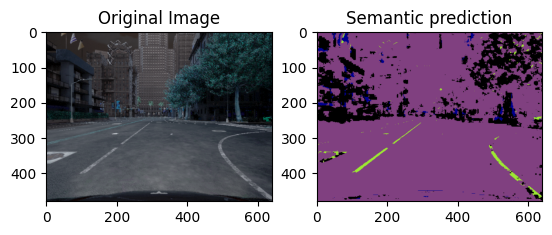

In [20]:
#try argmax conversion faster
from matplotlib import pyplot as plt #to show images in this notebook
import cv2
import numpy as np
import os
import random

from tensorflow.keras.models import load_model


model = load_model("model\RGB to semantic model attempt2",compile=False)

input_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\rgb'

input_image_files = [file for file in os.listdir(input_img_dir) if file.endswith('.png')]
random.shuffle(input_image_files)

# define reverse disctionary to go from one-hot to colours
color_to_label_mapping = {
    0: (0, 0, 0),  #Nothing
    1: (128, 64, 128),  #road
    2: (157, 234, 50),  #lane marking
    3: (0, 0, 142),     #cars
    4: (220, 220, 0)    #road signs
}

def convert_to_rgb(image):
    image = (np.squeeze(image[0].numpy()))

    rgb_img = np.zeros((image.shape[0],image.shape[1],3),dtype=np.uint8)
    #pick class with max probability
    rgb_img = np.argmax(image,axis=2)
    rgb_img = np.array([[color_to_label_mapping[value] for value in row] for row in rgb_img])
    return rgb_img

example_img = cv2.imread(os.path.join(input_img_dir,input_image_files[11])) # you can pick any image by changing number in last square brackets

# predict - this will give raw probabilities for all label classes
img = model(np.expand_dims(example_img, axis=0) / 255,training=False) 
plt.subplot(1, 2, 1), plt.imshow(example_img), plt.title('Original Image')
plt.subplot(1, 2, 2), plt.imshow(convert_to_rgb(img)), plt.title('Semantic prediction')
plt.show()  

In [15]:
# now we need a demo with video - this works but RGB BGR colours are off
#all imports
import carla #the sim library itself
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
import time

from matplotlib import pyplot as plt #to show images in this notebook

import os
import random
import tensorflow as tf
from tensorflow.keras.models import load_model

# connect to the sim 
client = carla.Client('localhost', 2000)

time.sleep(5)
client.set_timeout(25)
world = client.get_world()


model = load_model("model\RGB to semantic model attempt2",compile=False)


# define reverse disctionary to go from one-hot to colours
color_to_label_mapping = {
    0: (0, 0, 0),  #Nothing
    1: (128, 64, 128),  #road
    2: (157, 234, 50),  #lane marking
    3: (0, 0, 142),     #cars
    4: (220, 220, 0)    #road signs
}

def convert_to_rgb(image):
    image = (np.squeeze(image[0].numpy()))

    rgb_img = np.zeros((image.shape[0],image.shape[1],3),dtype=np.int32)
    #pick class with max probability
    rgb_img = np.argmax(image,axis=2)
    rgb_img = np.array([[color_to_label_mapping[value] for value in row] for row in rgb_img])
    return rgb_img

spawn_points = world.get_map().get_spawn_points()

#setting up a car with 2 cameras

# usual - spaw a car and set Autopilot on
vehicle_bp = world.get_blueprint_library().filter('*model3*')
start_point = spawn_points[0]
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)
vehicle.set_autopilot(True)

#camera mount offset on the car - you can tweak these to each car to avoid any parts of the car being in the view
CAMERA_POS_Z = 1.3 
CAMERA_POS_X = 1.4 
#semantic camera
camera_bp = world.get_blueprint_library().find('sensor.camera.semantic_segmentation')
camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.14 on Windows
camera_bp.set_attribute('image_size_y', '480')
camera_bp.set_attribute('fov', '90')

camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
camera_sem = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)

#normal rgb camera
camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.14 on Windows
camera_bp.set_attribute('image_size_y', '480')
camera_bp.set_attribute('fov', '90')
camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
camera_rgb = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)


def sem_callback(image,data_dict):
    ########## IMPORTANT CHANGE for Semantic camera ##############
    image.convert(carla.ColorConverter.CityScapesPalette)
    data_dict['sem_image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))
    
def rgb_callback(image,data_dict):
    data_dict['rgb_image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))

image_w = 640
image_h = 480

camera_data = {'sem_image': np.zeros((image_h,image_w,4)),
               'rgb_image': np.zeros((image_h,image_w,4))}

# this actually opens a live stream from the cameras
camera_sem.listen(lambda image: sem_callback(image,camera_data))
camera_rgb.listen(lambda image: rgb_callback(image,camera_data))

while True:
    camera_img = camera_data['rgb_image'] 
    sem_img = camera_data['sem_image'] 
    img = model(np.expand_dims(camera_img[:, :, :3], axis=0) / 255,training=False) 
    img_rgb = convert_to_rgb(img)
    #convert to same type
    img_rgb = img_rgb.astype(np.uint8)
    sem_img = sem_img.astype(np.uint8)
    alpha_channel = np.ones((img_rgb.shape[0], img_rgb.shape[1], 1), dtype=img_rgb.dtype) * 255
    img_rgb = np.concatenate((img_rgb, alpha_channel), axis=-1)
    #print("prediction Depth:", img_rgb.dtype, 'camera Depth: ',camera_img.dtype, 'shape of prediction:',img_rgb.shape)
    im_h = cv2.hconcat([sem_img,img_rgb])
    cv2.imshow('2 cameras', im_h)
    #cv2.imshow('prediction', img_rgb)
    
    # Break loop if user presses q
    if cv2.waitKey(1) == ord('q'):
        break

cv2.destroyAllWindows()
camera_sem.stop() # this is the opposite of camera.listen
camera_rgb.stop()

for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

In [13]:
sem_img.shape

(480, 640, 4)

In [14]:
img_rgb.shape

(480, 640, 3)

In [9]:

for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

In [16]:
sem_new = cv2.cvtColor(sem_img, cv2.COLOR_BGR2RGB)

In [17]:
sem_new.shape

(480, 640, 3)

In [20]:
# this is a working version of a demo to use model for prediction as video
#this gives same colours but green instead of yellow 
import carla #the sim library itself
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
import time

from matplotlib import pyplot as plt #to show images in this notebook

import os
import random
import tensorflow as tf
from tensorflow.keras.models import load_model

# connect to the sim 
client = carla.Client('localhost', 2000)

time.sleep(5)
client.set_timeout(25)
world = client.get_world()


model = load_model("model\RGB to semantic model attempt2",compile=False)


# define reverse disctionary to go from one-hot to colours
color_to_label_mapping = {
    0: (0, 0, 0),  #Nothing
    1: (128, 64, 128),  #road
    2: (157, 234, 50),  #lane marking
    3: (0, 0, 142),     #cars
    4: (220, 220, 0)    #road signs
}

def convert_to_rgb(image):
    image = (np.squeeze(image[0].numpy()))

    rgb_img = np.zeros((image.shape[0],image.shape[1],3),dtype=np.int32)
    #pick class with max probability
    rgb_img = np.argmax(image,axis=2)
    rgb_img = np.array([[color_to_label_mapping[value] for value in row] for row in rgb_img])
    return rgb_img

spawn_points = world.get_map().get_spawn_points()

#setting up a car with 2 cameras

# usual - spaw a car and set Autopilot on
vehicle_bp = world.get_blueprint_library().filter('*model3*')
start_point = spawn_points[0]
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)
vehicle.set_autopilot(True)

#camera mount offset on the car - you can tweak these to each car to avoid any parts of the car being in the view
CAMERA_POS_Z = 1.3 
CAMERA_POS_X = 1.4 
#semantic camera
camera_bp = world.get_blueprint_library().find('sensor.camera.semantic_segmentation')
camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.14 on Windows
camera_bp.set_attribute('image_size_y', '480')
camera_bp.set_attribute('fov', '90')

camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
camera_sem = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)
time.sleep(3)
#normal rgb camera
camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.14 on Windows
camera_bp.set_attribute('image_size_y', '480')
camera_bp.set_attribute('fov', '90')
camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
camera_rgb = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)


def sem_callback(image,data_dict):
    ########## IMPORTANT CHANGE for Semantic camera ##############
    image.convert(carla.ColorConverter.CityScapesPalette)
    data_dict['sem_image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))
    
def rgb_callback(image,data_dict):
    data_dict['rgb_image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))

image_w = 640
image_h = 480

camera_data = {'sem_image': np.zeros((image_h,image_w,4)),
               'rgb_image': np.zeros((image_h,image_w,4))}

# this actually opens a live stream from the cameras
camera_sem.listen(lambda image: sem_callback(image,camera_data))
camera_rgb.listen(lambda image: rgb_callback(image,camera_data))

while True:
    camera_img = camera_data['rgb_image'] 
    sem_img = camera_data['sem_image'] 
    sem_img = np.uint8(sem_img)
    sem_img = cv2.cvtColor(sem_img, cv2.COLOR_BGR2RGB)
    img = model(np.expand_dims(camera_img[:, :, :3], axis=0) / 255,training=False) 
    img_rgb = convert_to_rgb(img)
    #convert to same type
    img_rgb = img_rgb.astype(np.uint8)
    sem_img = sem_img.astype(np.uint8)
    #print("prediction Depth:", img_rgb.dtype, 'camera Depth: ',camera_img.dtype, 'shape of prediction:',img_rgb.shape)
    im_h = cv2.hconcat([sem_img,img_rgb])
    cv2.imshow('2 cameras', im_h)
    #cv2.imshow('prediction', img_rgb)
    
    # Break loop if user presses q
    if cv2.waitKey(1) == ord('q'):
        break

cv2.destroyAllWindows()
camera_sem.stop() # this is the opposite of camera.listen
camera_rgb.stop()

for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

KeyError: 5

In [1]:
#test on real Tesla video
# test model with custom loss interrupted on 5th epoch "UNET_LANES_WCE_LOSS-1680304258"

import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping

from matplotlib import pyplot as plt #to show images in this notebook

import os
import random
import tensorflow as tf
from tensorflow.keras.models import load_model

SIZE_X = 640
SIZE_Y = 480

m3_video = cv2.VideoCapture('C:/SelfDrive/Semantic segmentation/out_sem/tesla front camera example1.mp4')
model = load_model("model\RGB to semantic model attempt2",compile=False)

# define reverse disctionary to go from one-hot to colours
color_to_label_mapping = {
    0: (0, 0, 0),  #Nothing
    1: (128, 64, 128),  #road
    2: (157, 234, 50),  #lane marking
    3: (0, 0, 142),     #cars
    4: (220, 220, 0)    #road signs
}

def convert_to_rgb(image):
    image = (np.squeeze(image[0].numpy()))

    rgb_img = np.zeros((image.shape[0],image.shape[1],3),dtype=np.int32)
    #pick class with max probability
    rgb_img = np.argmax(image,axis=2)
    rgb_img = np.array([[color_to_label_mapping[value] for value in row] for row in rgb_img])
    return rgb_img


while(m3_video.isOpened()):
    # Capture frame-by-frame
    ret, frame = m3_video.read()
    if ret == True:
        # Display the resulting frameabs
        frame = cv2.resize(frame, (SIZE_X,SIZE_Y))
        frame = cv2.flip(frame, 1)

        img = model(np.expand_dims(frame[:, :, :3], axis=0) / 255,training=False) 
        img_rgb = convert_to_rgb(img)
        img_rgb = img_rgb.astype(np.uint8)
        frame = frame.astype(np.uint8)
        #cv2.imshow('predicted semantic',img_rgb)
        im_h = cv2.hconcat([frame,img_rgb])
        cv2.imshow('2 cameras', im_h)

        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
 
        # Break the loop
    else: 
        break
# When everything done, release the video capture object
m3_video.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [1]:
# use a more complex U net model from Google Bard and after generating many more training images

from tensorflow import keras
from tensorflow.keras import layers

def unet(input_shape=(480, 640, 3), num_classes=5):
  """
  Creates a U-Net model for semantic segmentation.

  Args:
    input_shape: Shape of the input image (height, width, channels).
    num_classes: Number of output classes for the segmentation mask.

  Returns:
    A Keras model for semantic segmentation.
  """

  inputs = keras.Input(shape=input_shape)

  # Encoder path
  down_block1 = downsample_block(inputs, filters=32)
  down_block2 = downsample_block(down_block1, filters=64)
  down_block3 = downsample_block(down_block2, filters=128)
  down_block4 = downsample_block(down_block3, filters=256)
  down_block5 = downsample_block(down_block4, filters=512)

  # Decoder path
  up_block1 = upsample_block(down_block5, down_block4, filters=256)
  up_block2 = upsample_block(up_block1, down_block3, filters=128)
  up_block3 = upsample_block(up_block2, down_block2, filters=64)
  up_block4 = upsample_block(up_block3, down_block1, filters=32)

  # Output layer
  outputs = keras.layers.Conv2D(num_classes, kernel_size=(1, 1), activation="softmax")(up_block4)

  model = keras.Model(inputs=inputs, outputs=outputs)

  return model

def downsample_block(inputs, filters):
  """
  Creates a downsampling block with convolution, batch normalization, and ReLU activation.

  Args:
    inputs: Tensor representing the input to the block.
    filters: Number of filters for the convolution layers.

  Returns:
    Tensor representing the output of the downsampling block.
  """

  x = keras.layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.MaxPooling2D((2, 2))(x)
  return x

def upsample_block(inputs, skip_connection, filters):
  """
  Creates an upsampling block with transposed convolution, concatenation with skip connection, convolution, batch normalization, and ReLU activation.

  Args:
    inputs: Tensor representing the input to the block.
    skip_connection: Tensor representing the skip connection from the encoder path.
    filters: Number of filters for the convolution layers.

  Returns:
    Tensor representing the output of the upsampling block.
  """

  x = keras.layers.Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding="same")(inputs)
  x = keras.layers.concatenate([x, skip_connection])
  x = keras.layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  return x

# Example usage
model = unet(input_shape=(480, 640, 3), num_classes=5)
model.summary()

# Compile and train the model
# ...

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 480, 640, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 480, 640, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
#making some changes to have out dimensions as 480x640
# added upsample block to take to original image size

# you can just run this code separately to check layer sizing of your model without a need to use actual data wit it

from tensorflow import keras
from tensorflow.keras import layers

def unet(input_shape=(480, 640, 3), num_classes=6):
  """
  Creates a U-Net model for semantic segmentation.

  Args:
    input_shape: Shape of the input image (height, width, channels).
    num_classes: Number of output classes for the segmentation mask.

  Returns:
    A Keras model for semantic segmentation.
  """

  inputs = keras.Input(shape=input_shape)

  # Encoder path
  down_block1 = downsample_block(inputs, filters=32)
  down_block2 = downsample_block(down_block1, filters=64)
  down_block3 = downsample_block(down_block2, filters=128)
  down_block4 = downsample_block(down_block3, filters=256)
  down_block5 = downsample_block(down_block4, filters=512)

  # Decoder path
  up_block1 = upsample_block(down_block5, down_block4, filters=256)
  up_block2 = upsample_block(up_block1, down_block3, filters=128)
  up_block3 = upsample_block(up_block2, down_block2, filters=64)
  up_block4 = upsample_block(up_block3, down_block1, filters=32)
  up_block5 = upsample_2_block(up_block4,inputs)

  # Output layer
  outputs = keras.layers.Conv2D(num_classes, kernel_size=(1, 1), activation="softmax")(up_block5)

  model = keras.Model(inputs=inputs, outputs=outputs)

  return model

def downsample_block(inputs, filters):
  """
  Creates a downsampling block with convolution, batch normalization, and ReLU activation.

  Args:
    inputs: Tensor representing the input to the block.
    filters: Number of filters for the convolution layers.

  Returns:
    Tensor representing the output of the downsampling block.
  """

  x = keras.layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.MaxPooling2D((2, 2))(x)
  return x

def upsample_block(inputs, skip_connection, filters):
  """
  Creates an upsampling block with transposed convolution, concatenation with skip connection, convolution, batch normalization, and ReLU activation.

  Args:
    inputs: Tensor representing the input to the block.
    skip_connection: Tensor representing the skip connection from the encoder path.
    filters: Number of filters for the convolution layers.

  Returns:
    Tensor representing the output of the upsampling block.
  """

  x = keras.layers.Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding="same")(inputs)
  x = keras.layers.concatenate([x, skip_connection])
  x = keras.layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  return x

def upsample_2_block(inputs,skip_connection):
  """
  Creates an upsampling block with to increase W and H by 2
  """
  x = keras.layers.UpSampling2D(size=(2, 2))(inputs)
  x = keras.layers.concatenate([x, skip_connection])
  return x

# Example usage
model = unet(input_shape=(480, 640, 3), num_classes=6)
model.summary()

# Compile and train the model
# ...

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_49 (Conv2D)             (None, 480, 640, 32  896         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_45 (BatchN  (None, 480, 640, 32  128        ['conv2d_49[0][0]']              
 ormalization)                  )                                                           

In [12]:
# now we need to recognise new colour in carla 9.15 - busses and bigger trucks
# seem to have slightly different semantic colour from normal cars 

#first show and example

import cv2
img = cv2.imread('C:/SelfDrive/Semantic segmentation/out_sem/sem/1703023953017537900.png')
cv2.imshow('Pick areas from here ',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [11]:
# Define the pixel coordinates of Tesla's bonnet
x = 320  # x-coordinate
y = 470  # y-coordinate

# Get the BGR values at the pixel
b, g, r = img[y, x]

# Print the RGB values
print(f"RGB values at ({x}, {y}): ({r}, {g}, {b})")

RGB values at (320, 470): (0, 0, 142)


In [13]:
# Define the pixel coordinates of The truck
x = 20  # x-coordinate
y = 240  # y-coordinate

# Get the BGR values at the pixel
b, g, r = img[y, x]

# Print the RGB values
print(f"RGB values at ({x}, {y}): ({r}, {g}, {b})")

RGB values at (20, 240): (0, 0, 70)


In [14]:
#so adding truck colours to colour mapping
# colour mapping
color_to_label_mapping = {
    (128, 64, 128): 1,
    (157, 234, 50): 2,
    (0, 0, 142): 3,
    (0, 0, 70):3,
    (220, 220, 0): 4  
}

In [18]:
# now a bus example
img = cv2.imread('C:/SelfDrive/Semantic segmentation/out_sem/sem/1703015594190040900.png')
cv2.imshow('Pick areas from here ',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [17]:
#bus colour
x = 480  # x-coordinate
y = 240  # y-coordinate

# Get the BGR values at the pixel
b, g, r = img[y, x]

# Print the RGB values
print(f"RGB values at ({x}, {y}): ({r}, {g}, {b})")

RGB values at (480, 240): (0, 60, 100)


In [19]:
#so adding bus colours to colour mapping
# colour mapping
color_to_label_mapping = {
    (128, 64, 128): 1,
    (157, 234, 50): 2,
    (0, 0, 142): 3,
    (0, 0, 70):3,
    (0, 60, 100):3,
    (220, 220, 0): 4  
}

In [20]:
#and adding pedestrians colours to colour mapping
# colour mapping
color_to_label_mapping = {
    (128, 64, 128): 1,
    (157, 234, 50): 2,
    (0, 0, 142): 3,
    (0, 0, 70):3,
    (0, 60, 100):3,
    (220, 220, 0): 4,  
    (220, 20, 60): 5
}

In [21]:
# confirm pedestrian
img = cv2.imread('C:/SelfDrive/Semantic segmentation/out_sem/sem/1703015605262532900.png')
cv2.imshow('Pick areas from here ',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
# confirm pedestrian 220, 20, 60 RGB values
x = 40  # x-coordinate
y = 240  # y-coordinate

# Get the BGR values at the pixel
b, g, r = img[y, x]

# Print the RGB values
print(f"RGB values at ({x}, {y}): ({r}, {g}, {b})")

RGB values at (40, 240): (220, 20, 60)


In [3]:
# copy and change full model training code from before
import os
import random
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.losses import categorical_crossentropy
from keras import backend as K

from matplotlib.path import Path

# define source folders
input_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\rgb'
output_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\sem'

NUM_CLASSES = 6

# Define the parameters for image preprocessing and augmentation
batch_size = 4

# function to create mask
def get_loss_mask(image):
    # constants for masking
    start_h = 0.52 # ingnore height up to this
    end_h = 0.94 # ignore bottom height from this 
    triangle_h = 1.6 # multiplier from start_h for triangle
    triangle_w = 0.38 # % of width ignored by triangle

    #take shape from any above image
    rows, cols = image.shape[0], image.shape[1]

    input_img = np.ones((rows, cols), dtype=np.uint8)

    # first triangle
    triangle_vertices = np.array([[0,int(input_img.shape[0]*start_h)], [0,int(start_h *input_img.shape[0] * triangle_h)], [int(input_img.shape[1]*triangle_w),int(input_img.shape[0]*start_h)]])
    triangle_path = Path(triangle_vertices)
    # Create a 2D grid of coordinates
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    # Flatten the coordinate grids and create an array of (x, y) points
    points = np.column_stack((x.flatten(), y.flatten()))
    # Create a boolean mask for the points inside the triangle
    triangle_mask1 = triangle_path.contains_points(points).reshape((rows, cols))
    # Create a copy of the original image with the triangle sliced

    # second triangle
    triangle_vertices = np.array([[int(input_img.shape[1]*(1-triangle_w)),int(input_img.shape[0]*start_h)], [input_img.shape[1],int(start_h *input_img.shape[0] * triangle_h)], [input_img.shape[1],int(input_img.shape[0]*start_h)]])
    triangle_path = Path(triangle_vertices)
    # Create a 2D grid of coordinates
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    # Flatten the coordinate grids and create an array of (x, y) points
    points = np.column_stack((x.flatten(), y.flatten()))
    # Create a boolean mask for the points inside the triangle
    triangle_mask2 = triangle_path.contains_points(points).reshape((rows, cols))

    # rectangle to ignore top
    rectangle_vertices = np.array([[0, 0], [input_img.shape[1], int(input_img.shape[0]*start_h)+1]])
    # Create a boolean mask for the rectangle
    rectangle_mask1 = np.zeros_like(input_img, dtype=bool)
    rectangle_mask1[
        np.min(rectangle_vertices[:, 1]):np.max(rectangle_vertices[:, 1]),
        np.min(rectangle_vertices[:, 0]):np.max(rectangle_vertices[:, 0]),
    ] = True

    # rectangle to ignore bottom
    rectangle_vertices = np.array([[0,int(input_img.shape[0]*end_h)],[input_img.shape[1],input_img.shape[0]]])
    # Create a boolean mask for the rectangle
    rectangle_mask2 = np.zeros_like(input_img, dtype=bool)
    rectangle_mask2[
        np.min(rectangle_vertices[:, 1]):np.max(rectangle_vertices[:, 1]),
        np.min(rectangle_vertices[:, 0]):np.max(rectangle_vertices[:, 0]),
    ] = True


    mask = np.copy(input_img)
    #mask[triangle_mask1] = 0  # Set non-triangle pixels to white
    #mask[triangle_mask2] = 0 # Set non-triangle pixels to white
    mask[rectangle_mask1] = 0
    mask[rectangle_mask2] = 0
    return mask

# Define color to label mapping
color_to_label_mapping = {
    (128, 64, 128): 1,
    (157, 234, 50): 2,
    (0, 0, 142): 3,
    (0, 0, 70):3,
    (0, 60, 100):3,
    (220, 220, 0): 4,  
    (220, 20, 60): 5
}

def rgb_to_onehot(rgb_image, color_to_label_mapping):
    # Convert the RGB image to a NumPy array
    image_array = np.array(rgb_image)

    # Create an empty array for one-hot encoded labels
    one_hot_labels = np.zeros((image_array.shape[0],image_array.shape[1]), dtype=np.uint8)

    # Replace colors with one-hot labels
    for color, label in color_to_label_mapping.items():
        mask = np.all(image_array == np.array(color), axis=-1)
        one_hot_labels[mask] = label
    # this conts classes from maping dict and extra one for all others
    num_classes = NUM_CLASSES
    unique_classes = np.unique(one_hot_labels)
    if not set(unique_classes).issubset(set(range(num_classes))):
        raise ValueError("Semantic image array contains # classes outside the range [0,", num_classes ,").")
    # apply one-hot
    one_hot_array = np.eye(num_classes)[one_hot_labels]
    return one_hot_array


# Get a list of image file paths and labels
input_image_files = [file for file in os.listdir(input_img_dir) if file.endswith('.png')]
random.shuffle(input_image_files)

#read one image to create mask
example_img = cv2.imread(os.path.join(input_img_dir,input_image_files[0]))
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
mask = get_loss_mask(example_img)

# get shape from the example image for the model
input_shape=example_img.shape


# Preprocess the image
def preprocess_rgb_image(image_path):
    image = cv2.imread(image_path)
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

def preprocess_sem_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    one_hot_result = rgb_to_onehot(image, color_to_label_mapping)
    return one_hot_result


# Create a custom data generator
def custom_data_generator(input_images, batch_size):
    num_samples = len(input_images)
    while True:
        indices = np.random.randint(0, num_samples, batch_size)
        batch_images = []  #input images
        batch_sem_images = [] # output images
        for idx in indices:
            input_image_name = input_images[idx]
            in_image = preprocess_rgb_image(os.path.join(input_img_dir,input_image_name))
            batch_images.append(in_image)
            out_image = preprocess_sem_image(os.path.join(output_img_dir,input_image_name)) #share same name so name of input image is used to ensure same picture in both
            batch_sem_images.append(out_image)
        yield np.array(batch_images), np.array(batch_sem_images)


def custom_categorical_loss(y_true, y_pred):
    """
    Custom categorical cross-entropy loss with weighted pixels based on a given mask.

    Parameters:
    - mask: A binary mask indicating the regions to be prioritized.
    - weight_factor: Weighting factor for the specified regions (default is 2.0).
    - num_classes: Number of classes in the segmentation task.

    Returns:
    - loss: Custom categorical cross-entropy loss.
    """
    weight_factor=2.0
    # Convert mask to a tensor
    mask_tensor = K.constant(mask, dtype=tf.float32)
    # Weight the mask regions with the specified factor
    weighted_mask = mask_tensor * weight_factor
    # Compute standard categorical cross-entropy loss
    standard_loss = categorical_crossentropy(y_true, y_pred)
    # Apply the weighted mask to the loss
    weighted_loss = weighted_mask * standard_loss
    # Calculate the mean loss over all pixels and classes
    loss=  K.mean(weighted_loss)
    return loss

def unet(input_shape=(480, 640, 3), num_classes=NUM_CLASSES):
  """
  Creates a U-Net model for semantic segmentation.

  Args:
    input_shape: Shape of the input image (height, width, channels).
    num_classes: Number of output classes for the segmentation mask.

  Returns:
    A Keras model for semantic segmentation.
  """

  inputs = keras.Input(shape=input_shape)

  # Encoder path
  down_block1 = downsample_block(inputs, filters=32)
  down_block2 = downsample_block(down_block1, filters=64)
  down_block3 = downsample_block(down_block2, filters=128)
  down_block4 = downsample_block(down_block3, filters=256)
  down_block5 = downsample_block(down_block4, filters=512)

  # Decoder path
  up_block1 = upsample_block(down_block5, down_block4, filters=256)
  up_block2 = upsample_block(up_block1, down_block3, filters=128)
  up_block3 = upsample_block(up_block2, down_block2, filters=64)
  up_block4 = upsample_block(up_block3, down_block1, filters=32)
  up_block5 = upsample_2_block(up_block4,inputs)

  # Output layer
  outputs = keras.layers.Conv2D(num_classes, kernel_size=(1, 1), activation="softmax")(up_block5)

  model = keras.Model(inputs=inputs, outputs=outputs)

  return model

def downsample_block(inputs, filters):
  """
  Creates a downsampling block with convolution, batch normalization, and ReLU activation.

  Args:
    inputs: Tensor representing the input to the block.
    filters: Number of filters for the convolution layers.

  Returns:
    Tensor representing the output of the downsampling block.
  """

  x = keras.layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.MaxPooling2D((2, 2))(x)
  return x

def upsample_block(inputs, skip_connection, filters):
  """
  Creates an upsampling block with transposed convolution, concatenation with skip connection, convolution, batch normalization, and ReLU activation.

  Args:
    inputs: Tensor representing the input to the block.
    skip_connection: Tensor representing the skip connection from the encoder path.
    filters: Number of filters for the convolution layers.

  Returns:
    Tensor representing the output of the upsampling block.
  """

  x = keras.layers.Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding="same")(inputs)
  x = keras.layers.concatenate([x, skip_connection])
  x = keras.layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  return x

def upsample_2_block(inputs,skip_connection):
  """
  Creates an upsampling block with to increase W and H by 2
  """
  x = keras.layers.UpSampling2D(size=(2, 2))(inputs)
  x = keras.layers.concatenate([x, skip_connection])
  return x

# Split the data into training and validation sets
split_index = int(len(input_image_files) * 0.8)  # 80% for training, 20% for validation
train_files, val_files = input_image_files[:split_index], input_image_files[split_index:]

# Create data generators for training and validation
train_generator = custom_data_generator(train_files, batch_size)
val_generator = custom_data_generator(val_files, batch_size)

model = unet(input_shape=input_shape, num_classes=NUM_CLASSES)
model.summary()

model.compile(loss=custom_categorical_loss,
              optimizer='adam')

# Train the model
model.fit(train_generator, steps_per_epoch=len(train_files) // batch_size, epochs=1,
          validation_data=val_generator, validation_steps=len(val_files) // batch_size)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 480, 640, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 480, 640, 32  128        ['conv2d_10[0][0]']              
 rmalization)                   )                                                           

In [4]:
#save first
model.save("model\semantic_seg_1epoch", overwrite=True,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

INFO:tensorflow:Assets written to: model\semantic_seg_1epoch\assets


INFO:tensorflow:Assets written to: model\semantic_seg_1epoch\assets


In [3]:
#test on real Tesla video
# test model with custom loss interrupted on 5th epoch "UNET_LANES_WCE_LOSS-1680304258"

import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping

from matplotlib import pyplot as plt #to show images in this notebook

import os
import random
import tensorflow as tf
from tensorflow.keras.models import load_model

SIZE_X = 640
SIZE_Y = 480

m3_video = cv2.VideoCapture('C:/SelfDrive/Semantic segmentation/out_sem/tesla front camera example.mp4')
model = load_model("model\semantic_seg_20epoch_in_one",compile=False)

# define reverse disctionary to go from one-hot to colours
color_to_label_mapping = {
    0: (0, 0, 0),  #Nothing
    1: (128, 64, 128),  #road
    2: (157, 234, 50),  #lane marking
    3: (0, 0, 142),     #cars
    4: (220, 220, 0),    #road signs
    5: (220, 20, 60) #pedestrians
}

def convert_to_rgb(image):
    image = (np.squeeze(image[0].numpy()))

    rgb_img = np.zeros((image.shape[0],image.shape[1],3),dtype=np.int32)
    #pick class with max probability
    rgb_img = np.argmax(image,axis=2)
    rgb_img = np.array([[color_to_label_mapping[value] for value in row] for row in rgb_img])
    return rgb_img


while(m3_video.isOpened()):
    # Capture frame-by-frame
    ret, frame = m3_video.read()
    if ret == True:
        # Display the resulting frameabs
        frame = cv2.resize(frame, (SIZE_X,SIZE_Y))
        #frame = cv2.flip(frame, 1)

        img = model(np.expand_dims(frame[:, :, :3], axis=0) / 255,training=False) 
        img_rgb = convert_to_rgb(img)
        img_rgb = img_rgb.astype(np.uint8)
        frame = frame.astype(np.uint8)
        #cv2.imshow('predicted semantic',img_rgb)
        im_h = cv2.hconcat([frame,img_rgb])
        cv2.imshow('2 cameras', im_h)

        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
 
        # Break the loop
    else: 
        break
# When everything done, release the video capture object
m3_video.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [5]:
# continue training
# instead of model def, this loads existing models 

import os
import random
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.losses import categorical_crossentropy
from keras import backend as K
from tensorflow.keras.models import load_model
from matplotlib.path import Path

# define source folders
input_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\rgb'
output_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\sem'

NUM_CLASSES = 6

# Define the parameters for image preprocessing and augmentation
batch_size = 8

# function to create mask
def get_loss_mask(image):
    # constants for masking
    start_h = 0.52 # ingnore height up to this
    end_h = 0.94 # ignore bottom height from this 
    triangle_h = 1.6 # multiplier from start_h for triangle
    triangle_w = 0.38 # % of width ignored by triangle

    #take shape from any above image
    rows, cols = image.shape[0], image.shape[1]

    input_img = np.ones((rows, cols), dtype=np.uint8)

    # first triangle
    triangle_vertices = np.array([[0,int(input_img.shape[0]*start_h)], [0,int(start_h *input_img.shape[0] * triangle_h)], [int(input_img.shape[1]*triangle_w),int(input_img.shape[0]*start_h)]])
    triangle_path = Path(triangle_vertices)
    # Create a 2D grid of coordinates
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    # Flatten the coordinate grids and create an array of (x, y) points
    points = np.column_stack((x.flatten(), y.flatten()))
    # Create a boolean mask for the points inside the triangle
    triangle_mask1 = triangle_path.contains_points(points).reshape((rows, cols))
    # Create a copy of the original image with the triangle sliced

    # second triangle
    triangle_vertices = np.array([[int(input_img.shape[1]*(1-triangle_w)),int(input_img.shape[0]*start_h)], [input_img.shape[1],int(start_h *input_img.shape[0] * triangle_h)], [input_img.shape[1],int(input_img.shape[0]*start_h)]])
    triangle_path = Path(triangle_vertices)
    # Create a 2D grid of coordinates
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    # Flatten the coordinate grids and create an array of (x, y) points
    points = np.column_stack((x.flatten(), y.flatten()))
    # Create a boolean mask for the points inside the triangle
    triangle_mask2 = triangle_path.contains_points(points).reshape((rows, cols))

    # rectangle to ignore top
    rectangle_vertices = np.array([[0, 0], [input_img.shape[1], int(input_img.shape[0]*start_h)+1]])
    # Create a boolean mask for the rectangle
    rectangle_mask1 = np.zeros_like(input_img, dtype=bool)
    rectangle_mask1[
        np.min(rectangle_vertices[:, 1]):np.max(rectangle_vertices[:, 1]),
        np.min(rectangle_vertices[:, 0]):np.max(rectangle_vertices[:, 0]),
    ] = True

    # rectangle to ignore bottom
    rectangle_vertices = np.array([[0,int(input_img.shape[0]*end_h)],[input_img.shape[1],input_img.shape[0]]])
    # Create a boolean mask for the rectangle
    rectangle_mask2 = np.zeros_like(input_img, dtype=bool)
    rectangle_mask2[
        np.min(rectangle_vertices[:, 1]):np.max(rectangle_vertices[:, 1]),
        np.min(rectangle_vertices[:, 0]):np.max(rectangle_vertices[:, 0]),
    ] = True


    mask = np.copy(input_img)
    #mask[triangle_mask1] = 0  # Set non-triangle pixels to white
    #mask[triangle_mask2] = 0 # Set non-triangle pixels to white
    mask[rectangle_mask1] = 0
    mask[rectangle_mask2] = 0
    return mask

# Define color to label mapping
color_to_label_mapping = {
    (128, 64, 128): 1,
    (157, 234, 50): 2,
    (0, 0, 142): 3,
    (0, 0, 70):3,
    (0, 60, 100):3,
    (220, 220, 0): 4,  
    (220, 20, 60): 5
}

def rgb_to_onehot(rgb_image, color_to_label_mapping):
    # Convert the RGB image to a NumPy array
    image_array = np.array(rgb_image)

    # Create an empty array for one-hot encoded labels
    one_hot_labels = np.zeros((image_array.shape[0],image_array.shape[1]), dtype=np.uint8)

    # Replace colors with one-hot labels
    for color, label in color_to_label_mapping.items():
        mask = np.all(image_array == np.array(color), axis=-1)
        one_hot_labels[mask] = label
    # this conts classes from maping dict and extra one for all others
    num_classes = NUM_CLASSES
    unique_classes = np.unique(one_hot_labels)
    if not set(unique_classes).issubset(set(range(num_classes))):
        raise ValueError("Semantic image array contains # classes outside the range [0,", num_classes ,").")
    # apply one-hot
    one_hot_array = np.eye(num_classes)[one_hot_labels]
    return one_hot_array


# Get a list of image file paths and labels
input_image_files = [file for file in os.listdir(input_img_dir) if file.endswith('.png')]
random.shuffle(input_image_files)

#read one image to create mask
example_img = cv2.imread(os.path.join(input_img_dir,input_image_files[0]))
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
mask = get_loss_mask(example_img)

# get shape from the example image for the model
input_shape=example_img.shape


# Preprocess the image
def preprocess_rgb_image(image_path):
    image = cv2.imread(image_path)
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

def preprocess_sem_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    one_hot_result = rgb_to_onehot(image, color_to_label_mapping)
    return one_hot_result


# Create a custom data generator
def custom_data_generator(input_images, batch_size):
    num_samples = len(input_images)
    while True:
        indices = np.random.randint(0, num_samples, batch_size)
        batch_images = []  #input images
        batch_sem_images = [] # output images
        for idx in indices:
            input_image_name = input_images[idx]
            in_image = preprocess_rgb_image(os.path.join(input_img_dir,input_image_name))
            batch_images.append(in_image)
            out_image = preprocess_sem_image(os.path.join(output_img_dir,input_image_name)) #share same name so name of input image is used to ensure same picture in both
            batch_sem_images.append(out_image)
        yield np.array(batch_images), np.array(batch_sem_images)


def custom_categorical_loss(y_true, y_pred):
    """
    Custom categorical cross-entropy loss with weighted pixels based on a given mask.

    Parameters:
    - mask: A binary mask indicating the regions to be prioritized.
    - weight_factor: Weighting factor for the specified regions (default is 2.0).
    - num_classes: Number of classes in the segmentation task.

    Returns:
    - loss: Custom categorical cross-entropy loss.
    """
    weight_factor=2.0
    # Convert mask to a tensor
    mask_tensor = K.constant(mask, dtype=tf.float32)
    # Weight the mask regions with the specified factor
    weighted_mask = mask_tensor * weight_factor
    # Compute standard categorical cross-entropy loss
    standard_loss = categorical_crossentropy(y_true, y_pred)
    # Apply the weighted mask to the loss
    weighted_loss = weighted_mask * standard_loss
    # Calculate the mean loss over all pixels and classes
    loss=  K.mean(weighted_loss)
    return loss


# Split the data into training and validation sets
split_index = int(len(input_image_files) * 0.8)  # 80% for training, 20% for validation
train_files, val_files = input_image_files[:split_index], input_image_files[split_index:]

# Create data generators for training and validation
train_generator = custom_data_generator(train_files, batch_size)
val_generator = custom_data_generator(val_files, batch_size)

model = load_model("model\semantic_seg_2epoch",compile=False)
model.compile(loss=custom_categorical_loss,optimizer='adam')

# Train the model
model.fit(train_generator, steps_per_epoch=len(train_files) // batch_size, epochs=2,
          validation_data=val_generator, validation_steps=len(val_files) // batch_size)

Epoch 1/2
9442/9442 [==============================] - 6883s 728ms/step - loss: 0.0388 - val_loss: 0.0420
Epoch 2/2
9442/9442 [==============================] - 6908s 732ms/step - loss: 0.0358 - val_loss: 0.0430


In [6]:
model.save("model\semantic_seg_4epoch", overwrite=False,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

INFO:tensorflow:Assets written to: model\semantic_seg_4epoch\assets


INFO:tensorflow:Assets written to: model\semantic_seg_4epoch\assets


In [7]:
# continue training from 2 epochs but with 4 batches
# instead of model def, this loads existing models 

import os
import random
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.losses import categorical_crossentropy
from keras import backend as K
from tensorflow.keras.models import load_model
from matplotlib.path import Path

# define source folders
input_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\rgb'
output_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\sem'

NUM_CLASSES = 6

# Define the parameters for image preprocessing and augmentation
batch_size = 4

# function to create mask
def get_loss_mask(image):
    # constants for masking
    start_h = 0.52 # ingnore height up to this
    end_h = 0.94 # ignore bottom height from this 
    triangle_h = 1.6 # multiplier from start_h for triangle
    triangle_w = 0.38 # % of width ignored by triangle

    #take shape from any above image
    rows, cols = image.shape[0], image.shape[1]

    input_img = np.ones((rows, cols), dtype=np.uint8)

    # first triangle
    triangle_vertices = np.array([[0,int(input_img.shape[0]*start_h)], [0,int(start_h *input_img.shape[0] * triangle_h)], [int(input_img.shape[1]*triangle_w),int(input_img.shape[0]*start_h)]])
    triangle_path = Path(triangle_vertices)
    # Create a 2D grid of coordinates
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    # Flatten the coordinate grids and create an array of (x, y) points
    points = np.column_stack((x.flatten(), y.flatten()))
    # Create a boolean mask for the points inside the triangle
    triangle_mask1 = triangle_path.contains_points(points).reshape((rows, cols))
    # Create a copy of the original image with the triangle sliced

    # second triangle
    triangle_vertices = np.array([[int(input_img.shape[1]*(1-triangle_w)),int(input_img.shape[0]*start_h)], [input_img.shape[1],int(start_h *input_img.shape[0] * triangle_h)], [input_img.shape[1],int(input_img.shape[0]*start_h)]])
    triangle_path = Path(triangle_vertices)
    # Create a 2D grid of coordinates
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    # Flatten the coordinate grids and create an array of (x, y) points
    points = np.column_stack((x.flatten(), y.flatten()))
    # Create a boolean mask for the points inside the triangle
    triangle_mask2 = triangle_path.contains_points(points).reshape((rows, cols))

    # rectangle to ignore top
    rectangle_vertices = np.array([[0, 0], [input_img.shape[1], int(input_img.shape[0]*start_h)+1]])
    # Create a boolean mask for the rectangle
    rectangle_mask1 = np.zeros_like(input_img, dtype=bool)
    rectangle_mask1[
        np.min(rectangle_vertices[:, 1]):np.max(rectangle_vertices[:, 1]),
        np.min(rectangle_vertices[:, 0]):np.max(rectangle_vertices[:, 0]),
    ] = True

    # rectangle to ignore bottom
    rectangle_vertices = np.array([[0,int(input_img.shape[0]*end_h)],[input_img.shape[1],input_img.shape[0]]])
    # Create a boolean mask for the rectangle
    rectangle_mask2 = np.zeros_like(input_img, dtype=bool)
    rectangle_mask2[
        np.min(rectangle_vertices[:, 1]):np.max(rectangle_vertices[:, 1]),
        np.min(rectangle_vertices[:, 0]):np.max(rectangle_vertices[:, 0]),
    ] = True


    mask = np.copy(input_img)
    #mask[triangle_mask1] = 0  # Set non-triangle pixels to white
    #mask[triangle_mask2] = 0 # Set non-triangle pixels to white
    mask[rectangle_mask1] = 0
    mask[rectangle_mask2] = 0
    return mask

# Define color to label mapping
color_to_label_mapping = {
    (128, 64, 128): 1,
    (157, 234, 50): 2,
    (0, 0, 142): 3,
    (0, 0, 70):3,
    (0, 60, 100):3,
    (220, 220, 0): 4,  
    (220, 20, 60): 5
}

def rgb_to_onehot(rgb_image, color_to_label_mapping):
    # Convert the RGB image to a NumPy array
    image_array = np.array(rgb_image)

    # Create an empty array for one-hot encoded labels
    one_hot_labels = np.zeros((image_array.shape[0],image_array.shape[1]), dtype=np.uint8)

    # Replace colors with one-hot labels
    for color, label in color_to_label_mapping.items():
        mask = np.all(image_array == np.array(color), axis=-1)
        one_hot_labels[mask] = label
    # this conts classes from maping dict and extra one for all others
    num_classes = NUM_CLASSES
    unique_classes = np.unique(one_hot_labels)
    if not set(unique_classes).issubset(set(range(num_classes))):
        raise ValueError("Semantic image array contains # classes outside the range [0,", num_classes ,").")
    # apply one-hot
    one_hot_array = np.eye(num_classes)[one_hot_labels]
    return one_hot_array


# Get a list of image file paths and labels
input_image_files = [file for file in os.listdir(input_img_dir) if file.endswith('.png')]
random.shuffle(input_image_files)

#read one image to create mask
example_img = cv2.imread(os.path.join(input_img_dir,input_image_files[0]))
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
mask = get_loss_mask(example_img)

# get shape from the example image for the model
input_shape=example_img.shape


# Preprocess the image
def preprocess_rgb_image(image_path):
    image = cv2.imread(image_path)
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

def preprocess_sem_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    one_hot_result = rgb_to_onehot(image, color_to_label_mapping)
    return one_hot_result


# Create a custom data generator
def custom_data_generator(input_images, batch_size):
    num_samples = len(input_images)
    while True:
        indices = np.random.randint(0, num_samples, batch_size)
        batch_images = []  #input images
        batch_sem_images = [] # output images
        for idx in indices:
            input_image_name = input_images[idx]
            in_image = preprocess_rgb_image(os.path.join(input_img_dir,input_image_name))
            batch_images.append(in_image)
            out_image = preprocess_sem_image(os.path.join(output_img_dir,input_image_name)) #share same name so name of input image is used to ensure same picture in both
            batch_sem_images.append(out_image)
        yield np.array(batch_images), np.array(batch_sem_images)


def custom_categorical_loss(y_true, y_pred):
    """
    Custom categorical cross-entropy loss with weighted pixels based on a given mask.

    Parameters:
    - mask: A binary mask indicating the regions to be prioritized.
    - weight_factor: Weighting factor for the specified regions (default is 2.0).
    - num_classes: Number of classes in the segmentation task.

    Returns:
    - loss: Custom categorical cross-entropy loss.
    """
    weight_factor=2.0
    # Convert mask to a tensor
    mask_tensor = K.constant(mask, dtype=tf.float32)
    # Weight the mask regions with the specified factor
    weighted_mask = mask_tensor * weight_factor
    # Compute standard categorical cross-entropy loss
    standard_loss = categorical_crossentropy(y_true, y_pred)
    # Apply the weighted mask to the loss
    weighted_loss = weighted_mask * standard_loss
    # Calculate the mean loss over all pixels and classes
    loss=  K.mean(weighted_loss)
    return loss


# Split the data into training and validation sets
split_index = int(len(input_image_files) * 0.8)  # 80% for training, 20% for validation
train_files, val_files = input_image_files[:split_index], input_image_files[split_index:]

# Create data generators for training and validation
train_generator = custom_data_generator(train_files, batch_size)
val_generator = custom_data_generator(val_files, batch_size)

model = load_model("model\semantic_seg_2epoch",compile=False)
model.compile(loss=custom_categorical_loss,optimizer='adam')

# Train the model
model.fit(train_generator, steps_per_epoch=len(train_files) // batch_size, epochs=4,
          validation_data=val_generator, validation_steps=len(val_files) // batch_size)

Epoch 1/4
18885/18885 [==============================] - 7042s 373ms/step - loss: 0.0409 - val_loss: 0.0385
Epoch 2/4
18885/18885 [==============================] - 6974s 369ms/step - loss: 0.0375 - val_loss: 0.0354
Epoch 3/4
18885/18885 [==============================] - 6943s 368ms/step - loss: 0.0348 - val_loss: 0.0360
Epoch 4/4
18885/18885 [==============================] - 6957s 368ms/step - loss: 0.0328 - val_loss: 0.0391


In [8]:
model.save("model\semantic_seg_6epoch", overwrite=False,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

INFO:tensorflow:Assets written to: model\semantic_seg_6epoch\assets


INFO:tensorflow:Assets written to: model\semantic_seg_6epoch\assets


In [17]:
# continue training from 6 epochs but with more batches
# instead of model def, this loads existing models 

import os
import random
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.losses import categorical_crossentropy
from keras import backend as K
from tensorflow.keras.models import load_model
from matplotlib.path import Path

# define source folders
input_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\rgb'
output_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\sem'

NUM_CLASSES = 6

# Define the parameters for image preprocessing and augmentation
batch_size = 12

# function to create mask
def get_loss_mask(image):
    # constants for masking
    start_h = 0.52 # ingnore height up to this
    end_h = 0.94 # ignore bottom height from this 
    triangle_h = 1.6 # multiplier from start_h for triangle
    triangle_w = 0.38 # % of width ignored by triangle

    #take shape from any above image
    rows, cols = image.shape[0], image.shape[1]

    input_img = np.ones((rows, cols), dtype=np.uint8)

    # first triangle
    triangle_vertices = np.array([[0,int(input_img.shape[0]*start_h)], [0,int(start_h *input_img.shape[0] * triangle_h)], [int(input_img.shape[1]*triangle_w),int(input_img.shape[0]*start_h)]])
    triangle_path = Path(triangle_vertices)
    # Create a 2D grid of coordinates
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    # Flatten the coordinate grids and create an array of (x, y) points
    points = np.column_stack((x.flatten(), y.flatten()))
    # Create a boolean mask for the points inside the triangle
    triangle_mask1 = triangle_path.contains_points(points).reshape((rows, cols))
    # Create a copy of the original image with the triangle sliced

    # second triangle
    triangle_vertices = np.array([[int(input_img.shape[1]*(1-triangle_w)),int(input_img.shape[0]*start_h)], [input_img.shape[1],int(start_h *input_img.shape[0] * triangle_h)], [input_img.shape[1],int(input_img.shape[0]*start_h)]])
    triangle_path = Path(triangle_vertices)
    # Create a 2D grid of coordinates
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    # Flatten the coordinate grids and create an array of (x, y) points
    points = np.column_stack((x.flatten(), y.flatten()))
    # Create a boolean mask for the points inside the triangle
    triangle_mask2 = triangle_path.contains_points(points).reshape((rows, cols))

    # rectangle to ignore top
    rectangle_vertices = np.array([[0, 0], [input_img.shape[1], int(input_img.shape[0]*start_h)+1]])
    # Create a boolean mask for the rectangle
    rectangle_mask1 = np.zeros_like(input_img, dtype=bool)
    rectangle_mask1[
        np.min(rectangle_vertices[:, 1]):np.max(rectangle_vertices[:, 1]),
        np.min(rectangle_vertices[:, 0]):np.max(rectangle_vertices[:, 0]),
    ] = True

    # rectangle to ignore bottom
    rectangle_vertices = np.array([[0,int(input_img.shape[0]*end_h)],[input_img.shape[1],input_img.shape[0]]])
    # Create a boolean mask for the rectangle
    rectangle_mask2 = np.zeros_like(input_img, dtype=bool)
    rectangle_mask2[
        np.min(rectangle_vertices[:, 1]):np.max(rectangle_vertices[:, 1]),
        np.min(rectangle_vertices[:, 0]):np.max(rectangle_vertices[:, 0]),
    ] = True


    mask = np.copy(input_img)
    #mask[triangle_mask1] = 0  # Set non-triangle pixels to white
    #mask[triangle_mask2] = 0 # Set non-triangle pixels to white
    mask[rectangle_mask1] = 0
    mask[rectangle_mask2] = 0
    return mask

# Define color to label mapping
color_to_label_mapping = {
    (128, 64, 128): 1,
    (157, 234, 50): 2,
    (0, 0, 142): 3,
    (0, 0, 70):3,
    (0, 60, 100):3,
    (220, 220, 0): 4,  
    (220, 20, 60): 5
}

def rgb_to_onehot(rgb_image, color_to_label_mapping):
    # Convert the RGB image to a NumPy array
    image_array = np.array(rgb_image)

    # Create an empty array for one-hot encoded labels
    one_hot_labels = np.zeros((image_array.shape[0],image_array.shape[1]), dtype=np.uint8)

    # Replace colors with one-hot labels
    for color, label in color_to_label_mapping.items():
        mask = np.all(image_array == np.array(color), axis=-1)
        one_hot_labels[mask] = label
    # this conts classes from maping dict and extra one for all others
    num_classes = NUM_CLASSES
    unique_classes = np.unique(one_hot_labels)
    if not set(unique_classes).issubset(set(range(num_classes))):
        raise ValueError("Semantic image array contains # classes outside the range [0,", num_classes ,").")
    # apply one-hot
    one_hot_array = np.eye(num_classes)[one_hot_labels]
    return one_hot_array


# Get a list of image file paths and labels
input_image_files = [file for file in os.listdir(input_img_dir) if file.endswith('.png')]
random.shuffle(input_image_files)

#read one image to create mask
example_img = cv2.imread(os.path.join(input_img_dir,input_image_files[0]))
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
mask = get_loss_mask(example_img)

# get shape from the example image for the model
input_shape=example_img.shape


# Preprocess the image
def preprocess_rgb_image(image_path):
    image = cv2.imread(image_path)
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

def preprocess_sem_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    one_hot_result = rgb_to_onehot(image, color_to_label_mapping)
    return one_hot_result


# Create a custom data generator
def custom_data_generator(input_images, batch_size):
    num_samples = len(input_images)
    while True:
        indices = np.random.randint(0, num_samples, batch_size)
        batch_images = []  #input images
        batch_sem_images = [] # output images
        for idx in indices:
            input_image_name = input_images[idx]
            in_image = preprocess_rgb_image(os.path.join(input_img_dir,input_image_name))
            batch_images.append(in_image)
            out_image = preprocess_sem_image(os.path.join(output_img_dir,input_image_name)) #share same name so name of input image is used to ensure same picture in both
            batch_sem_images.append(out_image)
        yield np.array(batch_images), np.array(batch_sem_images)


def custom_categorical_loss(y_true, y_pred):
    """
    Custom categorical cross-entropy loss with weighted pixels based on a given mask.

    Parameters:
    - mask: A binary mask indicating the regions to be prioritized.
    - weight_factor: Weighting factor for the specified regions (default is 2.0).
    - num_classes: Number of classes in the segmentation task.

    Returns:
    - loss: Custom categorical cross-entropy loss.
    """
    weight_factor=2.0
    # Convert mask to a tensor
    mask_tensor = K.constant(mask, dtype=tf.float32)
    # Weight the mask regions with the specified factor
    weighted_mask = mask_tensor * weight_factor
    # Compute standard categorical cross-entropy loss
    standard_loss = categorical_crossentropy(y_true, y_pred)
    # Apply the weighted mask to the loss
    weighted_loss = weighted_mask * standard_loss
    # Calculate the mean loss over all pixels and classes
    loss=  K.mean(weighted_loss)
    return loss


# Split the data into training and validation sets
split_index = int(len(input_image_files) * 0.8)  # 80% for training, 20% for validation
train_files, val_files = input_image_files[:split_index], input_image_files[split_index:]

# Create data generators for training and validation
train_generator = custom_data_generator(train_files, batch_size)
val_generator = custom_data_generator(val_files, batch_size)

model = load_model("model\semantic_seg_20epoch",compile=False)
model.compile(loss=custom_categorical_loss,optimizer='adam')

# Train the model
model.fit(train_generator, steps_per_epoch=len(train_files) // batch_size, epochs=4,
          validation_data=val_generator, validation_steps=len(val_files) // batch_size)

model.save("model\semantic_seg_24epoch", overwrite=False,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

Epoch 1/4
6295/6295 [==============================] - 7016s 1s/step - loss: 0.0237 - val_loss: 0.0239
Epoch 2/4
6295/6295 [==============================] - 7023s 1s/step - loss: 0.0236 - val_loss: 0.0238
Epoch 3/4
6295/6295 [==============================] - 7040s 1s/step - loss: 0.0228 - val_loss: 0.0245
Epoch 4/4
6295/6295 [==============================] - 6959s 1s/step - loss: 0.0227 - val_loss: 0.0249


INFO:tensorflow:Assets written to: model\semantic_seg_24epoch\assets


INFO:tensorflow:Assets written to: model\semantic_seg_24epoch\assets


In [21]:
# test in sim
import carla #the sim library itself
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
import time

from matplotlib import pyplot as plt #to show images in this notebook

import os
import random
import tensorflow as tf
from tensorflow.keras.models import load_model

# connect to the sim 
client = carla.Client('localhost', 2000)

time.sleep(5)
client.set_timeout(25)
world = client.get_world()


model = load_model("model\semantic_seg_24epoch",compile=False)


# define reverse disctionary to go from one-hot to colours
color_to_label_mapping = {
    0: (0, 0, 0),  #Nothing
    1: (128, 64, 128),  #road
    2: (157, 234, 50),  #lane marking
    3: (0, 0, 142),     #cars
    4: (220, 220, 0),    #road signs
    5: (220,20,60)
}

def convert_to_rgb(image):
    image = (np.squeeze(image[0].numpy()))

    rgb_img = np.zeros((image.shape[0],image.shape[1],3),dtype=np.int32)
    #pick class with max probability
    rgb_img = np.argmax(image,axis=2)
    rgb_img = np.array([[color_to_label_mapping[value] for value in row] for row in rgb_img])
    return rgb_img

spawn_points = world.get_map().get_spawn_points()

#setting up a car with 2 cameras

# usual - spaw a car and set Autopilot on
vehicle_bp = world.get_blueprint_library().filter('*model3*')
start_point = spawn_points[0]
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)
vehicle.set_autopilot(True)

#camera mount offset on the car - you can tweak these to each car to avoid any parts of the car being in the view
CAMERA_POS_Z = 1.3 
CAMERA_POS_X = 1.4 
#semantic camera
camera_bp = world.get_blueprint_library().find('sensor.camera.semantic_segmentation')
camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.14 on Windows
camera_bp.set_attribute('image_size_y', '480')
camera_bp.set_attribute('fov', '90')

camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
camera_sem = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)
time.sleep(3)
#normal rgb camera
camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.14 on Windows
camera_bp.set_attribute('image_size_y', '480')
camera_bp.set_attribute('fov', '90')
camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
camera_rgb = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)


def sem_callback(image,data_dict):
    ########## IMPORTANT CHANGE for Semantic camera ##############
    image.convert(carla.ColorConverter.CityScapesPalette)
    data_dict['sem_image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))
    
def rgb_callback(image,data_dict):
    data_dict['rgb_image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))

image_w = 640
image_h = 480

camera_data = {'sem_image': np.zeros((image_h,image_w,4)),
               'rgb_image': np.zeros((image_h,image_w,4))}

# this actually opens a live stream from the cameras
camera_sem.listen(lambda image: sem_callback(image,camera_data))
camera_rgb.listen(lambda image: rgb_callback(image,camera_data))

while True:
    camera_img = camera_data['rgb_image'] 
    sem_img = camera_data['sem_image'] 
    sem_img = np.uint8(sem_img)
    sem_img = cv2.cvtColor(sem_img, cv2.COLOR_BGR2RGB)
    img = model(np.expand_dims(camera_img[:, :, :3], axis=0) / 255,training=False) 
    img_rgb = convert_to_rgb(img)
    #convert to same type
    img_rgb = img_rgb.astype(np.uint8)
    sem_img = sem_img.astype(np.uint8)
    #print("prediction Depth:", img_rgb.dtype, 'camera Depth: ',camera_img.dtype, 'shape of prediction:',img_rgb.shape)
    im_h = cv2.hconcat([sem_img,img_rgb])
    cv2.imshow('2 cameras', im_h)
    #cv2.imshow('prediction', img_rgb)
    
    # Break loop if user presses q
    if cv2.waitKey(1) == ord('q'):
        break

cv2.destroyAllWindows()
camera_sem.stop() # this is the opposite of camera.listen
camera_rgb.stop()

for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

: 

In [1]:
# copy and change full model training code from before
import os
import random
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.losses import categorical_crossentropy
from keras import backend as K

from matplotlib.path import Path

# define source folders
input_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\rgb'
output_img_dir = 'C:\\SelfDrive\\Semantic segmentation\\out_sem\\sem'

NUM_CLASSES = 6

# Define the parameters for image preprocessing and augmentation
batch_size = 10

# function to create mask
def get_loss_mask(image):
    # constants for masking
    start_h = 0.52 # ingnore height up to this
    end_h = 0.94 # ignore bottom height from this 
    triangle_h = 1.6 # multiplier from start_h for triangle
    triangle_w = 0.38 # % of width ignored by triangle

    #take shape from any above image
    rows, cols = image.shape[0], image.shape[1]

    input_img = np.ones((rows, cols), dtype=np.uint8)

    # first triangle
    triangle_vertices = np.array([[0,int(input_img.shape[0]*start_h)], [0,int(start_h *input_img.shape[0] * triangle_h)], [int(input_img.shape[1]*triangle_w),int(input_img.shape[0]*start_h)]])
    triangle_path = Path(triangle_vertices)
    # Create a 2D grid of coordinates
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    # Flatten the coordinate grids and create an array of (x, y) points
    points = np.column_stack((x.flatten(), y.flatten()))
    # Create a boolean mask for the points inside the triangle
    triangle_mask1 = triangle_path.contains_points(points).reshape((rows, cols))
    # Create a copy of the original image with the triangle sliced

    # second triangle
    triangle_vertices = np.array([[int(input_img.shape[1]*(1-triangle_w)),int(input_img.shape[0]*start_h)], [input_img.shape[1],int(start_h *input_img.shape[0] * triangle_h)], [input_img.shape[1],int(input_img.shape[0]*start_h)]])
    triangle_path = Path(triangle_vertices)
    # Create a 2D grid of coordinates
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    # Flatten the coordinate grids and create an array of (x, y) points
    points = np.column_stack((x.flatten(), y.flatten()))
    # Create a boolean mask for the points inside the triangle
    triangle_mask2 = triangle_path.contains_points(points).reshape((rows, cols))

    # rectangle to ignore top
    rectangle_vertices = np.array([[0, 0], [input_img.shape[1], int(input_img.shape[0]*start_h)+1]])
    # Create a boolean mask for the rectangle
    rectangle_mask1 = np.zeros_like(input_img, dtype=bool)
    rectangle_mask1[
        np.min(rectangle_vertices[:, 1]):np.max(rectangle_vertices[:, 1]),
        np.min(rectangle_vertices[:, 0]):np.max(rectangle_vertices[:, 0]),
    ] = True

    # rectangle to ignore bottom
    rectangle_vertices = np.array([[0,int(input_img.shape[0]*end_h)],[input_img.shape[1],input_img.shape[0]]])
    # Create a boolean mask for the rectangle
    rectangle_mask2 = np.zeros_like(input_img, dtype=bool)
    rectangle_mask2[
        np.min(rectangle_vertices[:, 1]):np.max(rectangle_vertices[:, 1]),
        np.min(rectangle_vertices[:, 0]):np.max(rectangle_vertices[:, 0]),
    ] = True


    mask = np.copy(input_img)
    #mask[triangle_mask1] = 0  # Set non-triangle pixels to white
    #mask[triangle_mask2] = 0 # Set non-triangle pixels to white
    mask[rectangle_mask1] = 0
    mask[rectangle_mask2] = 0
    return mask

# Define color to label mapping
color_to_label_mapping = {
    (128, 64, 128): 1,
    (157, 234, 50): 2,
    (0, 0, 142): 3,
    (0, 0, 70):3,
    (0, 60, 100):3,
    (220, 220, 0): 4,  
    (220, 20, 60): 5
}

def rgb_to_onehot(rgb_image, color_to_label_mapping):
    # Convert the RGB image to a NumPy array
    image_array = np.array(rgb_image)

    # Create an empty array for one-hot encoded labels
    one_hot_labels = np.zeros((image_array.shape[0],image_array.shape[1]), dtype=np.uint8)

    # Replace colors with one-hot labels
    for color, label in color_to_label_mapping.items():
        mask = np.all(image_array == np.array(color), axis=-1)
        one_hot_labels[mask] = label
    # this conts classes from maping dict and extra one for all others
    num_classes = NUM_CLASSES
    unique_classes = np.unique(one_hot_labels)
    if not set(unique_classes).issubset(set(range(num_classes))):
        raise ValueError("Semantic image array contains # classes outside the range [0,", num_classes ,").")
    # apply one-hot
    one_hot_array = np.eye(num_classes)[one_hot_labels]
    return one_hot_array


# Get a list of image file paths and labels
input_image_files = [file for file in os.listdir(input_img_dir) if file.endswith('.png')]
random.shuffle(input_image_files)

#read one image to create mask
example_img = cv2.imread(os.path.join(input_img_dir,input_image_files[0]))
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
mask = get_loss_mask(example_img)

# get shape from the example image for the model
input_shape=example_img.shape


# Preprocess the image
def preprocess_rgb_image(image_path):
    image = cv2.imread(image_path)
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

def preprocess_sem_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    one_hot_result = rgb_to_onehot(image, color_to_label_mapping)
    return one_hot_result


# Create a custom data generator
def custom_data_generator(input_images, batch_size):
    num_samples = len(input_images)
    while True:
        indices = np.random.randint(0, num_samples, batch_size)
        batch_images = []  #input images
        batch_sem_images = [] # output images
        for idx in indices:
            input_image_name = input_images[idx]
            in_image = preprocess_rgb_image(os.path.join(input_img_dir,input_image_name))
            batch_images.append(in_image)
            out_image = preprocess_sem_image(os.path.join(output_img_dir,input_image_name)) #share same name so name of input image is used to ensure same picture in both
            batch_sem_images.append(out_image)
        yield np.array(batch_images), np.array(batch_sem_images)


def custom_categorical_loss(y_true, y_pred):
    """
    Custom categorical cross-entropy loss with weighted pixels based on a given mask.

    Parameters:
    - mask: A binary mask indicating the regions to be prioritized.
    - weight_factor: Weighting factor for the specified regions (default is 2.0).
    - num_classes: Number of classes in the segmentation task.

    Returns:
    - loss: Custom categorical cross-entropy loss.
    """
    weight_factor=2.0
    # Convert mask to a tensor
    mask_tensor = K.constant(mask, dtype=tf.float32)
    # Weight the mask regions with the specified factor
    weighted_mask = mask_tensor * weight_factor
    # Compute standard categorical cross-entropy loss
    standard_loss = categorical_crossentropy(y_true, y_pred)
    # Apply the weighted mask to the loss
    weighted_loss = weighted_mask * standard_loss
    # Calculate the mean loss over all pixels and classes
    loss=  K.mean(weighted_loss)
    return loss

def unet(input_shape=(480, 640, 3), num_classes=NUM_CLASSES):
  """
  Creates a U-Net model for semantic segmentation.

  Args:
    input_shape: Shape of the input image (height, width, channels).
    num_classes: Number of output classes for the segmentation mask.

  Returns:
    A Keras model for semantic segmentation.
  """

  inputs = keras.Input(shape=input_shape)

  # Encoder path
  down_block1 = downsample_block(inputs, filters=32)
  down_block2 = downsample_block(down_block1, filters=64)
  down_block3 = downsample_block(down_block2, filters=128)
  down_block4 = downsample_block(down_block3, filters=256)
  down_block5 = downsample_block(down_block4, filters=512)

  # Decoder path
  up_block1 = upsample_block(down_block5, down_block4, filters=256)
  up_block2 = upsample_block(up_block1, down_block3, filters=128)
  up_block3 = upsample_block(up_block2, down_block2, filters=64)
  up_block4 = upsample_block(up_block3, down_block1, filters=32)
  up_block5 = upsample_2_block(up_block4,inputs)

  # Output layer
  outputs = keras.layers.Conv2D(num_classes, kernel_size=(1, 1), activation="softmax")(up_block5)

  model = keras.Model(inputs=inputs, outputs=outputs)

  return model

def downsample_block(inputs, filters):
  """
  Creates a downsampling block with convolution, batch normalization, and ReLU activation.

  Args:
    inputs: Tensor representing the input to the block.
    filters: Number of filters for the convolution layers.

  Returns:
    Tensor representing the output of the downsampling block.
  """

  x = keras.layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.MaxPooling2D((2, 2))(x)
  return x

def upsample_block(inputs, skip_connection, filters):
  """
  Creates an upsampling block with transposed convolution, concatenation with skip connection, convolution, batch normalization, and ReLU activation.

  Args:
    inputs: Tensor representing the input to the block.
    skip_connection: Tensor representing the skip connection from the encoder path.
    filters: Number of filters for the convolution layers.

  Returns:
    Tensor representing the output of the upsampling block.
  """

  x = keras.layers.Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding="same")(inputs)
  x = keras.layers.concatenate([x, skip_connection])
  x = keras.layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  return x

def upsample_2_block(inputs,skip_connection):
  """
  Creates an upsampling block with to increase W and H by 2
  """
  x = keras.layers.UpSampling2D(size=(2, 2))(inputs)
  x = keras.layers.concatenate([x, skip_connection])
  return x

# Split the data into training and validation sets
split_index = int(len(input_image_files) * 0.8)  # 80% for training, 20% for validation
train_files, val_files = input_image_files[:split_index], input_image_files[split_index:]

# Create data generators for training and validation
train_generator = custom_data_generator(train_files, batch_size)
val_generator = custom_data_generator(val_files, batch_size)

model = unet(input_shape=input_shape, num_classes=NUM_CLASSES)
model.summary()

model.compile(loss=custom_categorical_loss,
              optimizer='adam')

# Train the model
model.fit(train_generator, steps_per_epoch=len(train_files) // batch_size, epochs=20,
          validation_data=val_generator, validation_steps=len(val_files) // batch_size)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 480, 640, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 480, 640, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [2]:
model.save("model\semantic_seg_20epoch_in_one", overwrite=False,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

INFO:tensorflow:Assets written to: model\semantic_seg_20epoch_in_one\assets


INFO:tensorflow:Assets written to: model\semantic_seg_20epoch_in_one\assets
